### Motivation

We want a generator for ambiguities constructed out of infinite partial wave ampltiudes.
The observation is that both $$F(z)= \frac{z-z_1}{1-z_1} f(z)$$ and $$\tilde{F}(z)= \frac{z-z^\star_1}{1-z^\star_1} f(z)$$ have the same modulus. The goal is then to see whether for a fixed $z_1$ value we can learn the appropriate $f(z)$ such that both $F(z),\tilde{F}(z)$ satisfy the integral unitarity equation. 

### Implementation

##### Start with the necessary imports and device setting

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR, ExponentialLR, MultiplicativeLR
from torch import Generator
import math
from collections import OrderedDict
import numpy as np
from itertools import chain
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt



In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

##### Define a network architecture for representing an amplitude $f(z)$

In [3]:
class ModuleNetAmplitude(nn.Module):
    """
    Class for parametrizing the amplitude 
    """
    
    def __init__(self, ffnlayers, disconnected=True, complex_pred=True, input_size=1, device='cpu'):
        super(ModuleNetAmplitude, self).__init__()
        self.device = device
        self.activation = nn.ReLU()
        self.disconnected = disconnected
        self.complex_pred = complex_pred
        self.positive_activ = nn.Softplus()
        self.input_size = input_size
        
        self.layer_sizes = ffnlayers
        
        if self.disconnected:
            self.model_1 = nn.Sequential(OrderedDict(self.build_network_layers()))
            self.model_2 = nn.Sequential(OrderedDict(self.build_network_layers()))
            self.model = [self.model_1, self.model_2]
        else:
            self.model = nn.Sequential(OrderedDict(self.build_network_layers()))
        
        
    def forward(self, x):
        """
        Network forward pass where the outputs are either (Real part, Im part) or (Mod, Phase)
        """
        if self.complex_pred:
            if self.disconnected:
                return self.model[0](x), self.model[1](x)
            else:
                x = self.model(x)
                return x[..., 0:1], x[..., 1:2]
        else:
            if self.disconnected:
                return self.positive_activ(self.model[1](x)), torch.tanh(self.model[0](x))*math.pi
            else:
                x = self.model(x)
                return self.positive_activ(x[..., 1:2]), torch.tanh(x[..., 0:1])*math.pi
    
    def build_network_layers(self):

        layer_list = []

        for i, layer_size in enumerate(self.layer_sizes):
            if i == 0:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(self.input_size, layer_size)))
                layer_list.append(('activation_%d' % (i+1), self.activation))
            else:
                layer_list.append(('layer_%d' % (i+1), nn.Linear(self.layer_sizes[i-1], layer_size)))
                layer_list.append(('activation_%d' %(i+1), self.activation))

        # The pre final layer has one or two outputs depending on whether the nets are disconnected
        size_out = 1 if self.disconnected else 2
        layer_list.append(('layer_%d' % (len(self.layer_sizes)+1), nn.Linear(self.layer_sizes[-1], size_out)))

        return layer_list

##### Define a model which has for output the two different amplitudes $F(z)$ and $\tilde{F}(z)$

Start with some helper functions

In [4]:
def mod_zero(x, rez, imz):
    """
    Calculate the Mod, making sure to use only real numbers
    """
    
    return torch.sqrt(((x-rez)*(1-rez)+imz**2)**2 + imz**2*(x-1)**2)/(imz**2+(1-rez)**2)

def arg_zero(x, rez , imz):
    """
    Calculate the Phase, making sure to use only real numbers
    """ 
    
    return torch.atan2(imz*(x-1), (x-rez)*(1-rez)+imz**2)

def finite_p_wave(x, phase_shifts, opp=False):
    """
    From a set of phase shifts, construct the associated unitary partial wave expansion 
    """
    if opp:
        mult=-1
    else:
        mult=1
    coeffs = [(2*i+1) * np.exp(1j*phase_s*mult)*np.sin(phase_s*mult) for i, phase_s in enumerate(phase_shifts)]
    
    return np.polynomial.legendre.legval(x, coeffs)

Define the module that represents the final two amplitudes

In [5]:
class ModuleAmplitudes(nn.Module):
    """
    Class for parametrizing the two different amplitudes used
    """
    
    def __init__(self, ffnlayers, zeros_changed, disconnected=True, complex_pred=True, device='cpu'):
        super(ModuleAmplitudes, self).__init__()
        self.device = device
        self.complex_pred = complex_pred
        self.disconnected = disconnected
        self.zeros = zeros_changed
        self.base_in_dim = 1
        self.base_f = ModuleNetAmplitude(ffnlayers, device=device, disconnected=disconnected, complex_pred=complex_pred, input_size=self.base_in_dim)
    
    def set_zeros(self, new_zeros, keep_grad=False):
        self.zeros = torch.tensor(new_zeros, device=self.device, requires_grad=keep_grad, dtype=torch.float32)
        if keep_grad:
            return self.zeros
    
    def forward(self, x):
        """
        Forward pass where we return the mod and phase for both amplitudes
        """
        fx = self.base_f(x)

        if self.complex_pred:
            fx = torch.sqrt(fx[0]**2 + fx[1]**2), torch.atan2(fx[1],fx[0])
        
        mods = [mod_zero(x, zero_in[0], zero_in[1]) for zero_in in self.zeros]
        phases = [arg_zero(x, zero_in[0], zero_in[1]) for zero_in in self.zeros]
        
        mods_tot = torch.prod(torch.stack(mods), dim=0)
        phases_tot = torch.sum(torch.stack(phases), dim=0)

        return fx[0] * mods_tot,  torch.atan2(torch.sin(fx[1] + phases_tot), torch.cos(fx[1] + phases_tot)), torch.atan2(torch.sin(fx[1] - phases_tot), torch.cos(fx[1] - phases_tot))
        

In [6]:
class ModuleAmplitudes(nn.Module):
    """
    Class for parametrizing the two different amplitudes used
    """
    
    def __init__(self, ffnlayers, zeros_changed, disconnected=True, complex_pred=True, device='cpu'):
        super(ModuleAmplitudes, self).__init__()
        self.device = device
        self.complex_pred = complex_pred
        self.disconnected = disconnected
        self.zeros = zeros_changed
        self.base_in_dim = 1
        self.base_f = ModuleNetAmplitude(ffnlayers, device=device, disconnected=disconnected, complex_pred=complex_pred, input_size=self.base_in_dim)
    
    def set_zeros(self, new_zeros, keep_grad=False):
        self.zeros = torch.tensor(new_zeros, device=self.device, requires_grad=keep_grad, dtype=torch.float32)
        if keep_grad:
            return self.zeros
    
    def forward(self, x):
        """
        Forward pass where we return the mod and phase for both amplitudes
        """
        fx = self.base_f(x)

        if self.complex_pred:
            fx = torch.sqrt(fx[0]**2 + fx[1]**2), torch.atan2(fx[1],fx[0])
        
        mods = [mod_zero(x, zero_in[0], zero_in[1]) for zero_in in self.zeros]
        phases = [arg_zero(x, zero_in[0], zero_in[1]) for zero_in in self.zeros]
        
        mods_tot = torch.prod(torch.stack(mods), dim=0)
        phases_tot = torch.sum(torch.stack(phases), dim=0)

        return fx[0] * mods_tot,  torch.atan2(torch.sin(fx[1] + phases_tot), torch.cos(fx[1] + phases_tot)), torch.atan2(torch.sin(fx[1] - phases_tot), torch.cos(fx[1] - phases_tot))
        

##### Main solver class

In [7]:
class PhaseNetSolverA():
    """
    Main class for crafting the simulation
    """
    def __init__(self, params_simu, amps_net, optimizer, random_generator, scheduler, device='cpu'):
        """
        Initialize the simulation with the networks, the loss function and the optimizer
        """
        
        self.epochs = params_simu['epochs_num']
        self.batch_size = params_simu['batch_size']
        self.eval_points_num = params_simu['integral_points']
        self.scaled_loss = params_simu['scaled_loss']
        self.method_int = params_simu['method_int']
        self.loss_func = params_simu['loss']
        self.repulsive_epochs = params_simu['repulsive_epochs']
        self.p_value = params_simu['p_value']
        self.lambda_repulsive = params_simu['lambda_repulsive']        

        self.amps_net = amps_net.to(device)
        self.device = device
        self.rand_gen = random_generator
        
        self.optimizer = optimizer
        self.scheduler = scheduler
    
    def z2(self, z, z1, phi):
        """
        Compute the z2 parameter (formula in motivation)
        Place the batch size on first dim, z1 on the second and phi on the third
        """
        term1 = z.unsqueeze(dim=0).transpose(0, 1) * (z1.unsqueeze(dim=0))
        term2 = torch.sqrt(1 - torch.square(z)).unsqueeze(dim=0).transpose(0, 1) * torch.sqrt(1 - torch.square(z1)).unsqueeze(dim=0)
        return term1.unsqueeze(dim=2) + term2.unsqueeze(dim=2)*torch.cos(phi.unsqueeze(dim=0)).view(1,1,-1)
    
    def integral_approximator(self, z, method='trapz'):
        """
        Approximate the value of the RHS of the integral equation.
        Compute the grids of z1 and phi points for given z values and integrate over the grids
        """
        
        # Linear partition of the space
        z1_points = torch.linspace(-1,1,steps=self.eval_points_num, device=self.device, requires_grad=False)
        phi_points = torch.linspace(0, 2*math.pi, steps=self.eval_points_num, device=self.device, requires_grad=False)
        dx_z1 = 2/(self.eval_points_num-1)
        dx_phi = 2*math.pi/(self.eval_points_num-1)
        
        z1_point_data = self.amps_net(z1_points.view(1,-1,1))
        z2_point_data = self.amps_net(self.z2(z, z1_points, phi_points).unsqueeze(dim=-1))
        
        grid_mod = z1_point_data[0]*z2_point_data[0].squeeze() 
        grid_points1 = grid_mod*torch.cos(z1_point_data[1] - z2_point_data[1].squeeze())
        grid_points2 = grid_mod*torch.cos(z1_point_data[2] - z2_point_data[2].squeeze())
        
        # Simple trapezoid exists in PyTorch
        if method == 'trapz':
            integral1 = torch.trapezoid(torch.trapezoid(grid_points1, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
            integral2 = torch.trapezoid(torch.trapezoid(grid_points2, dx=dx_phi), dx=dx_z1)/(4*math.pi) 
        
        return integral1, integral2
    
    
    def sin_mu_integral(self, z, method='trapz'):
        """
        Helper function to compute the sin(\mu) variable.
        This compute the relevant integral involving the differential cross section
        """
        z1_points = torch.linspace(-1,1,steps=self.eval_points_num, device=self.device, requires_grad=False)
        phi_points = torch.linspace(0, 2*math.pi, steps=self.eval_points_num, device=self.device, requires_grad=False)
        dx_z1 = 2/(self.eval_points_num-1)
        dx_phi = 2*math.pi/(self.eval_points_num-1)
        
        z1_point_data = self.amps_net(z1_points.view(1,-1,1))
        z2_point_data = self.amps_net(self.z2(z, z1_points, phi_points).unsqueeze(dim=-1))
        
        grid_mod = z1_point_data[0]*z2_point_data[0].squeeze() 
        
        # Simple trapezoid exists in PyTorch
        if method == 'trapz':
            integral = torch.trapezoid(torch.trapezoid(grid_mod, dx=dx_phi), dx=dx_z1)/(4*math.pi) 

        return integral
    
  
    def loss_function(self, zsamples):
        """
        Compute a loss based on the average residuals for the integral equation
        """
        
        # For each value of z we estimate the integral equation
        sample_data = self.amps_net(zsamples.view(-1,1))
        target1 = torch.sin(sample_data[1]).squeeze() if self.scaled_loss else (sample_data[0]*torch.sin(sample_data[1])).squeeze()
        target2 = torch.sin(sample_data[2]).squeeze() if self.scaled_loss else (sample_data[0]*torch.sin(sample_data[2])).squeeze()
        
        model_input1, model_input2 = self.integral_approximator(zsamples, method=self.method_int)
        
        factor_div = 1
        reduction_loss = 'mean'
        
        if self.scaled_loss:
            model_input1 = model_input1/sample_data[0].squeeze()
            model_input2 = model_input2/sample_data[0].squeeze()
        
        if self.loss_func =='Huber':
            loss_out1 = F.huber_loss(model_input1, target1, delta=0.1, reduction=reduction_loss)/factor_div
            loss_out2 = F.huber_loss(model_input2, target2, delta=0.1, reduction=reduction_loss)/factor_div
        elif self.loss_func == 'MSE':
            loss_out1 = F.mse_loss(model_input1, target1, reduction=reduction_loss)/factor_div
            loss_out2 = F.mse_loss(model_input2, target2, reduction=reduction_loss)/factor_div
        else:
            raise NotImplemented
        
        return loss_out1 + loss_out2
    
    def dual_loss_ambiguity(self, zsamples, multiple_out=False):
        """
        In our repulsive loss setup we only consider the decaying repulsive loss here
        """
        sample_data = self.amps_net(zsamples.view(-1,1))
             
        target = torch.stack((torch.cos(sample_data[1].squeeze()), torch.sin(sample_data[1].squeeze())))
        model_input1 = torch.stack((torch.cos(sample_data[2].squeeze()), torch.sin(sample_data[2].squeeze())))
        model_input2 = torch.stack((-torch.cos(sample_data[2].squeeze()), torch.sin(sample_data[2].squeeze())))
        
        loss_out1 = 1-torch.tanh(self.p_value * F.mse_loss(model_input1, target))
        loss_out2 = 1-torch.tanh(self.p_value * F.mse_loss(model_input2, target))
        
        if multiple_out:
            return [loss_out1, loss_out2]
        
        loss_tot = loss_out1 + loss_out2

        return loss_tot

    
    def complete_loss(self, zsamples, dual_active):
        """
        Add all the losses together
        """
        unitarity_loss = self.loss_function(zsamples)
        if dual_active and self.lambda_repulsive > 0:
            ambiguity_loss = self.dual_loss_ambiguity(zsamples)
            
            if ambiguity_loss * 10 > unitarity_loss:
                return unitarity_loss + self.lambda_repulsive * ambiguity_loss
            else:
                return unitarity_loss
        else:
            return unitarity_loss

    
    def point_loss(self, zsamples):
        """
        If we want to know the residuals at each given z point. This is useful for evaluation purposes
        """
        sample_data = self.amps_net(zsamples.view(-1,1))
        
        target1 = torch.ones(zsamples.size(), device=self.device) if self.scaled_loss else (sample_data[0]*torch.sin(sample_data[1])).squeeze()
        target2 = torch.ones(zsamples.size(), device=self.device) if self.scaled_loss else (sample_data[0]*torch.sin(sample_data[2])).squeeze()
        model_input1, model_input2 = self.integral_approximator(zsamples)
        
        if self.scaled_loss:
            model_input1 = model_input1 / (sample_data[0]*torch.sin(sample_data[1])).squeeze()
            model_input2 = model_input2 / (sample_data[0]*torch.sin(sample_data[2])).squeeze()
        return torch.square(model_input1 - target1), torch.square(model_input2 - target2)
        
    def train(self):
        """
        Main training loop. 
        Each epoch is a single optimization step over a unique batch.
        A batch is composed of a number of randomly selected z points between -1 and 1
        """
        
        optim_rep = self.optimizer
        p_value_init = self.p_value
       
        tq_iterator = tqdm(range(self.epochs), unit='epoch', leave=False)
        
        for epoch_num in tq_iterator:
            
            
            if self.lambda_repulsive == 0.0:
                dual_active = False
            else:
                dual_active = True
        
            self.p_value = repulsive_decay_func(p_value_init, epoch_num, self.repulsive_epochs)
        
            self.amps_net.train()
        
            if self.device is not torch.device('cuda'):
                zpoints = torch.rand(self.batch_size, requires_grad=False, generator=self.rand_gen, device='cpu').to(self.device)*2 - 1          
            else:
                zpoints = torch.rand(self.batch_size, requires_grad=False, generator=self.rand_gen, device=self.device)*2 - 1        

            
            # Zero the grads, get the loss and backpropagate
            if isinstance(optim_rep, list):
                # Can use one optimizer first and the other afterwards
                if epoch_num < 0.5*self.epochs:
                    self.optimizer = optim_rep[0]
                else:
                    self.optimizer = optim_rep[1]
            
            if type(self.optimizer).__name__ == 'LBFGS':
                
                def closure():
                    self.optimizer.zero_grad()
                    loss_comp = self.complete_loss(zpoints, dual_active)
                    if loss_comp.requires_grad:
                        loss_comp.backward(retain_graph=False)
                    else:
                        print('here no grad required')
                    return loss_comp
                loss = self.optimizer.step(closure)
                   
            else:
                self.optimizer.zero_grad()
                loss = self.complete_loss(zpoints, dual_active)
                loss.backward()
                self.optimizer.step()
                
            if self.scheduler is not None:
                self.scheduler.step()
            
            tq_iterator.set_description('Train Epoch: {} ; tLoss: {:.6f}'.format(epoch_num,loss.item()))

Functions required for the Learning rate scheduler and the repulsive loss

In [8]:
def scheduler_rate_exp(step, gamma, max_ep, repulsive_end):
    """
    For the Exponential Learning Rate scheduler where we decay only after the repulsive loss
    
    """
    if step < 0.3 * min(5000, max_ep) or step < repulsive_end/4:
        return 1
    else:
        return gamma
    
def repulsive_decay_func(p_value_init, epoch_num, repulsive_epochs, overall_scale=16):
    """
    Construct a profile function for the increase in the temperature parameter used
    in the repulsive loss
    """
    
    # Construct a hyperbolic tanh function with a maximum slope at the middle of the repulsive interval
    # The hyperbolic function reaches 0.99 at the end of the repulsive interval
    a = (repulsive_epochs[0] + repulsive_epochs[1])/(2*math.atanh((100-99*overall_scale)/(100-101*overall_scale)))
    b = (repulsive_epochs[1] - repulsive_epochs[0])/(2*a)
    
    delta1 = p_value_init *(101*overall_scale - 100) /200
    delta2 = p_value_init *(99*overall_scale + 100) /200
    
    return delta1*np.tanh(-b+epoch_num/a) + delta2

##### Define the training and evaluation runs

In [9]:
def train_run(parameters, device, seed_num=42, optim_name='Adam', amps_net=None):
    """
    Function to call for launching the training run
    """
    # Fix for the generator : For reproducibility between cpu and MPS
    random_gen_cpu = Generator(device='cpu')
    random_gen_cpu.manual_seed(seed_num)
    torch.manual_seed(seed_num)   
    torch.cuda.manual_seed(seed_num)
    
    
    # Define and register the networks
    if amps_net is None:
        amps_net = ModuleAmplitudes(parameters['layer_list'], parameters['zeros'], disconnected=parameters['disconnected'], complex_pred=parameters['complex_pred'], device=device)
    else:
        amps_net = amps_net    
    
    # Define and register the optimizer and scheduler
    if optim_name == 'Adam':
        optimizer = torch.optim.Adam(amps_net.parameters(), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']), weight_decay=0.000000)
    elif optim_name == 'LBFGS':
        optimizer = torch.optim.LBFGS(amps_net.parameters(), lr=parameters['learning_rate'], max_iter=10, history_size=20, line_search_fn = None, tolerance_grad=1e-20, tolerance_change=1e-20)
    elif optim_name =='Both':   
        optimizer1 = torch.optim.Adam(amps_net.parameters(), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']))
        optimizer2 = torch.optim.LBFGS(amps_net.parameters(), lr=parameters['learning_rate'], max_iter=10, history_size=20, line_search_fn = None, tolerance_grad=1e-20, tolerance_change=1e-20)
    
    if parameters['lr_scheduler']:
        lr_scheduler = MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda step: scheduler_rate_exp(step, 0.999, parameters['epochs_num'], parameters['repulsive_epochs'][1]))
    else:
        lr_scheduler = None
    
    # Create the simulation, train it and return the trained result
    netsolver = PhaseNetSolverA(parameters, amps_net, optimizer, random_gen_cpu, lr_scheduler, device=device)
    
    # Launch the training run
    netsolver.train()

    return netsolver

In [10]:
def create_solver_with_net(parameters, device, amps_net, seed_num=42):
    """
    Function to call for creating the netsolver framework
    """
    # Fix for the generator : For reproducibility between cpu and MPS
    random_gen_cpu = Generator(device='cpu')
    random_gen_cpu.manual_seed(seed_num)
    torch.manual_seed(seed_num)   
    torch.cuda.manual_seed(seed_num)
    
    # Define the optimizer and scheduler
    optimizer = torch.optim.Adam(amps_net.parameters(), lr=parameters['learning_rate'], betas=(parameters['beta1'], parameters['beta2']), weight_decay=0.000000)
    lr_scheduler = MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda step: scheduler_rate_exp(step, 0.999, parameters['epochs_num'], parameters['repulsive_epochs'][1]))
    
    # Create the simulation, train it and return the trained result
    netsolver = PhaseNetSolverA(parameters, amps_net, optimizer, random_gen_cpu, lr_scheduler, device=device)

    return netsolver

In [11]:
def eval_run_amp(trained_solver, params, device, steps_eval=100, num=None):
    """
    At evaluation we verify if the integral equation is satisfied. 
    For this we take a larger sample of z points
    """
    
    str_add = '_' + str(num) if num is not None else ''
    
    # Make sure we are in evaluation mode
    trained_solver.amps_net.eval()
    
    with torch.no_grad(): 
        
        # Create the evaluation points and compute the phase at those points
        zpointstest = torch.linspace(-1,1,steps=steps_eval, device=device)
        test_data = trained_solver.amps_net(zpointstest.view(-1,1))
        
        mod_res = test_data[0].squeeze().cpu().numpy()
        phase_1 = test_data[1].squeeze().cpu().numpy()
        phase_2 = test_data[2].squeeze().cpu().numpy()
        
        # Also log the final loss values. Including the loss at individual z values
        trained_solver.scaled_loss = True
        eval_loss_scaled = trained_solver.loss_function(zpointstest)
        pt_losses = trained_solver.point_loss(zpointstest)
        eval_point_loss_scaled = [pt_losses[0] , pt_losses[1]]
        
        trained_solver.scaled_loss = False
        eval_loss_base = trained_solver.loss_function(zpointstest)
        pt_losses_non_scaled = trained_solver.point_loss(zpointstest)
        eval_point_loss_non_scaled = [pt_losses_non_scaled[0], pt_losses_non_scaled[1]]
        
    
    return zpointstest, mod_res, [phase_1, phase_2], eval_point_loss_scaled, eval_point_loss_non_scaled, eval_loss_scaled, eval_loss_base

##### Define the plotting functions

In [12]:
def sin_mu_integral(trained_solver, zpoints, keep_grad=False):
    """
    Helper function to compute the sin(\mu) variable defined in the motivation.
    This compute the relevant integral involving the differential cross section
    """
    if keep_grad:
        num_integral = trained_solver.sin_mu_integral(zpoints)
        return num_integral/trained_solver.amps_net(zpoints.view(-1,1))[0].squeeze()
    else:
        with torch.no_grad(): 
            num_integral = trained_solver.sin_mu_integral(zpoints)
            return num_integral/trained_solver.amps_net(zpoints.view(-1,1))[0].squeeze()

    
def plot_bmod(zpoints, bpoints, add_str=''):

    fig = plt.figure(figsize=(14, 10))
    plt.plot(zpoints.cpu(),bpoints, '-', linewidth = 2)       
    plt.xlabel('$z$')
    plt.ylabel('$B(z)$')    
    plt.title('Differential cross section prediction ' + add_str, fontsize = 15)
    plt.legend(['$B(z)$ predicted'])
    plt.xlim([-1,1])
    plt.show()
    plt.close(fig)    

    
def plot_phases(zpoints, phipoints_list, add_str=''):

    fig = plt.figure(figsize=(14, 10))
    for phipoints in phipoints_list:
        plt.plot(zpoints.cpu(),phipoints, '-', linewidth = 2)       
    plt.xlabel('$z$')
    plt.ylabel('$\phi(z)$')    
    plt.title('$\phi(z)$ prediction '+ add_str, fontsize = 15)
    plt.legend(['Network {}'.format(i+1) for i in range(len(phipoints_list))])
    plt.xlim([-1,1])
    plt.show()
    plt.close(fig)
        

def plot_point_losses(zpoints, point_loss_data_ses, point_loss_data_noses):

    fig = plt.figure(figsize=(14, 10))
    for point_loss_data_s in point_loss_data_ses:
        plt.plot(zpoints.cpu(), np.log10(point_loss_data_s.cpu()), '-', linewidth = 2)  
    
    plt.gca().set_prop_cycle(None)
    for point_loss_data_nos in point_loss_data_noses:
        plt.plot(zpoints.cpu(), np.log10(point_loss_data_nos.cpu()), '--', linewidth = 2)  
    plt.xlabel('$z$')
    plt.ylabel('$\log_{10} ||\mathcal{L}(z)||_2$')    
    plt.title('Point loss evaluation', fontsize = 15)
    plt.xlim([-1,1])
    legendstr = ['Network {} : Normalized point loss'.format(i+1) for i in range(len(point_loss_data_ses))] + ['Network {} : Base point loss'.format(i+1) for i in range(len(point_loss_data_noses))]
    plt.legend(legendstr)
    plt.show()
    plt.close(fig)

def plot_sin_mu(zpoints, integralpoints):

    sinmu = max(integralpoints.cpu())
    fig2 = plt.figure(figsize=(14, 10))

    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.title('Differential cross section categorization: Learned B(z)', fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(['$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()
    plt.close(fig2)
    

def plot_summaries(zpoints, phipoints_list, integralpoints):
    
    sinmu = max(integralpoints.cpu())
    
    fig3 = plt.figure(figsize=(14, 10))
    cmap = plt.get_cmap("tab10")
    
    legend_list = []
    for i, phipoints in enumerate(phipoints_list):
        plt.plot(zpoints.cpu(),phipoints, color=cmap(i), linestyle = '-', linewidth = 2)       
        plt.plot(zpoints.cpu(), np.sin(phipoints), color=cmap(i), linestyle = '--', linewidth = 2)       
        legend_list.extend(['Network $\phi_{}(z)$'.format(i), 'Network $\sin \phi_{}(z)$'.format(i)])
        
    plt.plot(zpoints.cpu(),integralpoints.cpu(), 'g-', linewidth = 2)   
    plt.plot(zpoints.cpu(),sinmu.repeat(integralpoints.size(dim=0)), 'r--' )
    plt.xlabel('$z$')
    plt.ylabel('$\sin \mu(z)$')    
    plt.title('Differential cross section categorization: Learned B(z)', fontsize = 15)
    plt.xlim([-1,1])
    plt.legend(legend_list + ['$\sin\mu(z)$','$\sin \mu$={}'.format(str(np.round(sinmu.numpy(),4)))])
    plt.show()
    plt.close(fig3)
        

### Recovering Atkinson's ambiguities

#### Start with a fixed $z_1$ point

We will consider a domain where we know that we can recover an ambiguity. For this we follow the infinite partial wave solutions given by Atkinson

##### Pretrain at $z_1 = 1.2 + 0.6 i$

  0%|          | 0/5000 [00:00<?, ?epoch/s]

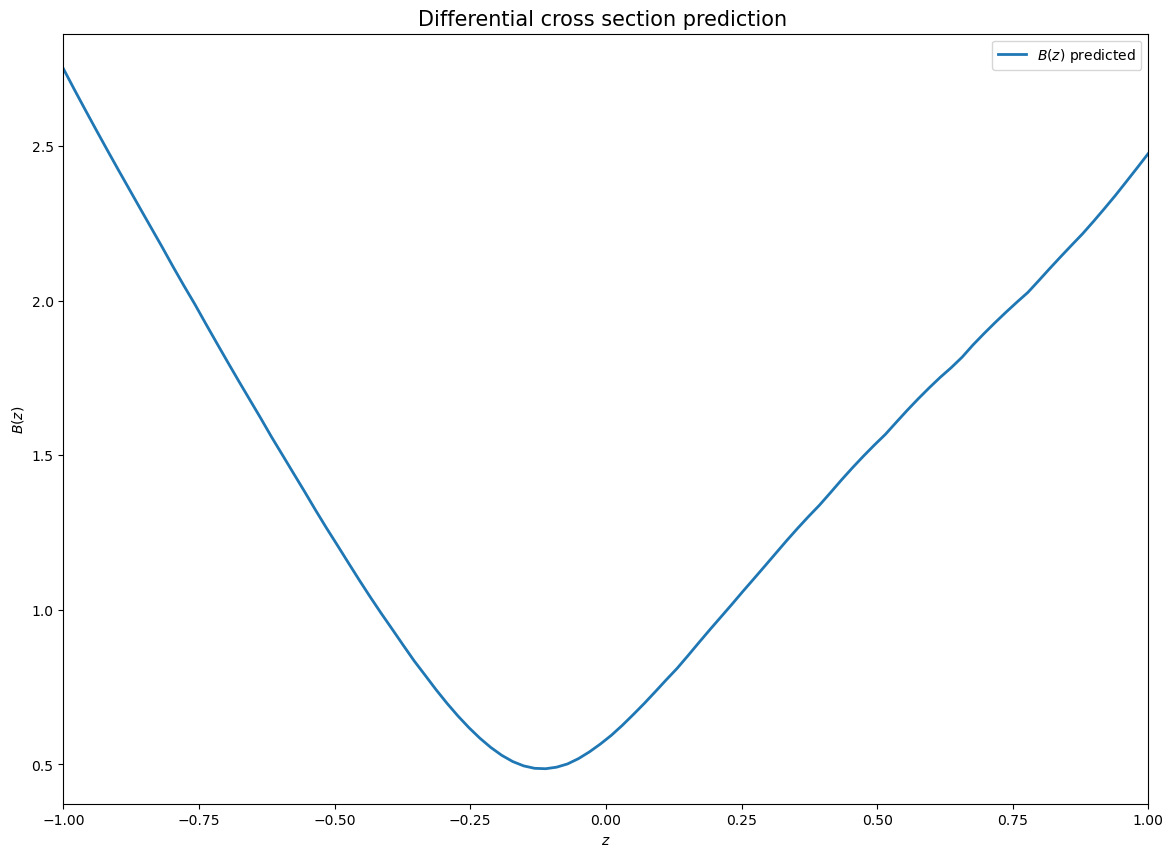

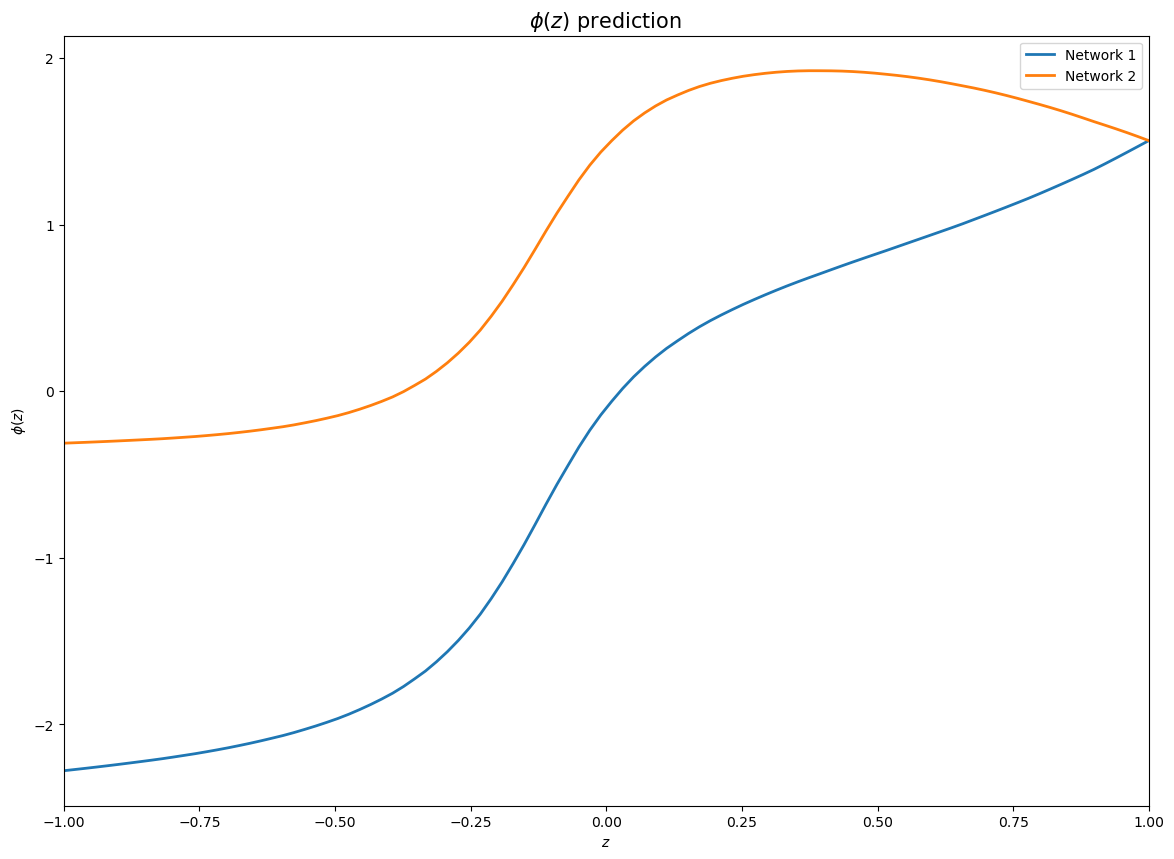

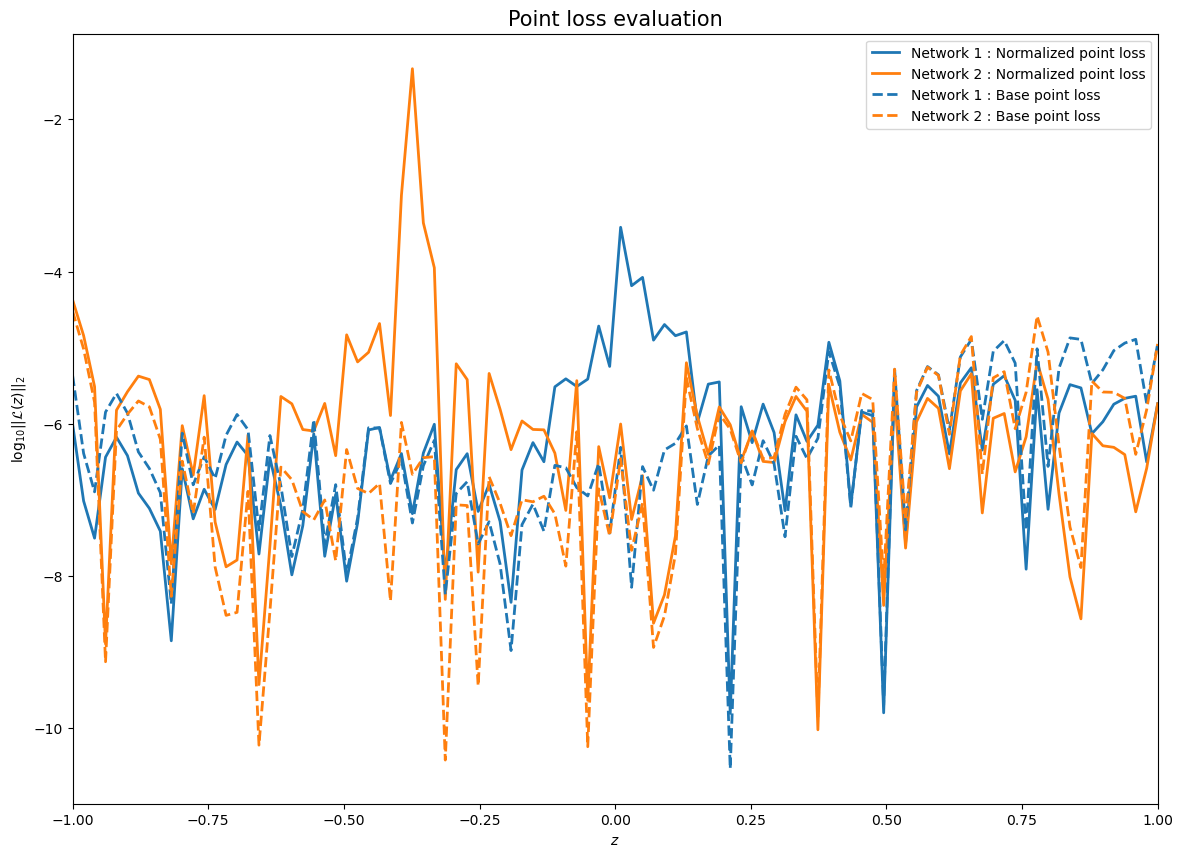

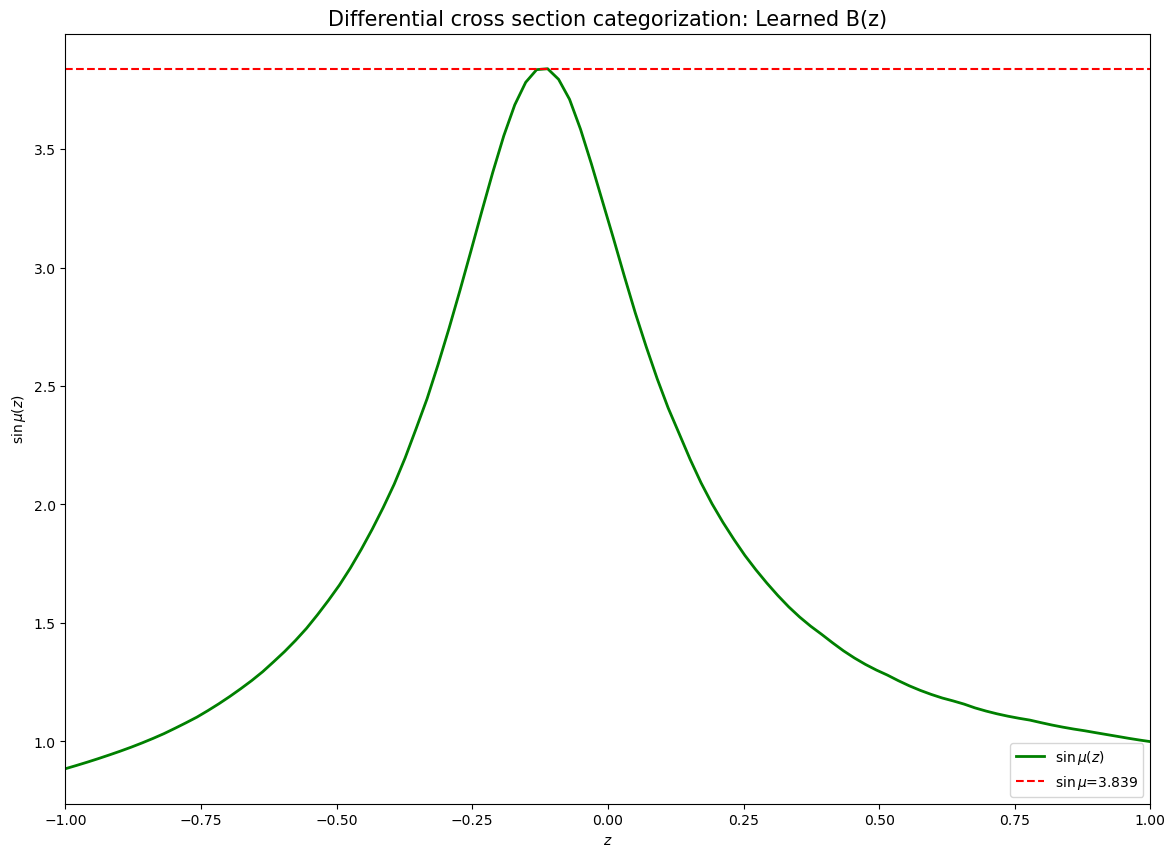

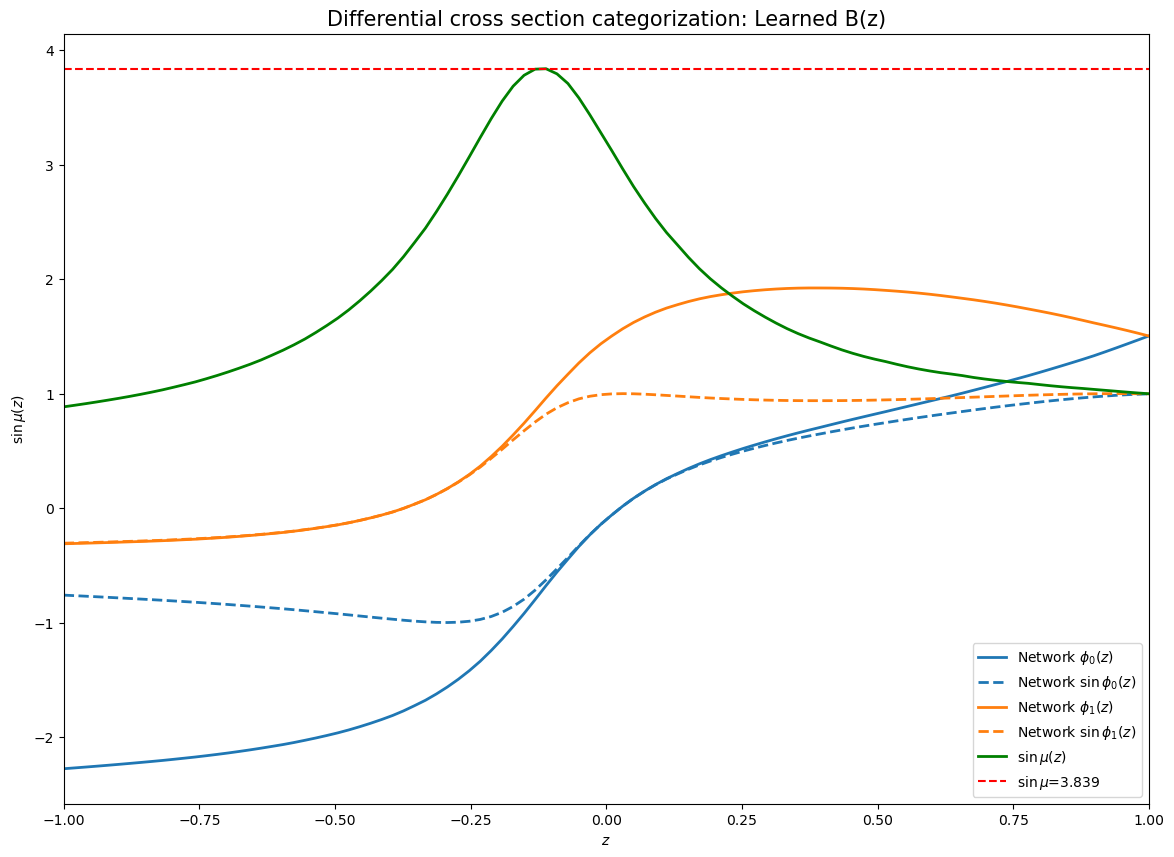

In [13]:
params = {'batch_size': 64,
         'epochs_num': 5000,
         'repulsive_epochs': [0, 1000],
         'learning_rate': 0.003,
         'lr_scheduler': True, 
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'layer_list': [64, 64, 64, 64],
         'loss': 'MSE',
         'scaled_loss': True,
         'zeros': [[1.2, 0.6]],
         'disconnected': False,
         'complex_pred': True,
         'p_value': 2,
         'lambda_repulsive':2.0}

netsolver_fixed = train_run(params, device, seed_num=42, optim_name='Adam')

zpointseval, modeval, phievals, eval_pt_loss_s, eval_pt_loss_no_s, _, _  = eval_run_amp(netsolver_fixed, params, device)

plot_bmod(zpointseval, modeval)
plot_phases(zpointseval, phievals)
plot_point_losses(zpointseval, eval_pt_loss_s, eval_pt_loss_no_s)

integralz = sin_mu_integral(netsolver_fixed, zpointseval)
plot_sin_mu(zpointseval, integralz)

plot_summaries(zpointseval, phievals, integralz)

In [100]:
# Compare to known values (with classical Atkinson algorithm)
amp1 = finite_p_wave(zpointseval.cpu().numpy(), [0.15667, 1.05784, -0.18036, -0.03881, -0.00656, -0.00104, -0.00017, -0.266*10**(-4), -0.428*10**(-5), -0.697*10**(-6), -0.114*10**(-6)])
amp2 = finite_p_wave(zpointseval.cpu().numpy(), [-0.94207, 0.83471, -0.18036, -0.03881, -0.00656, -0.00104, -0.00017, -0.266*10**(-4), -0.428*10**(-5), -0.697*10**(-6), -0.114*10**(-6)], opp=True)

Plotting against the prediction by Atkinson

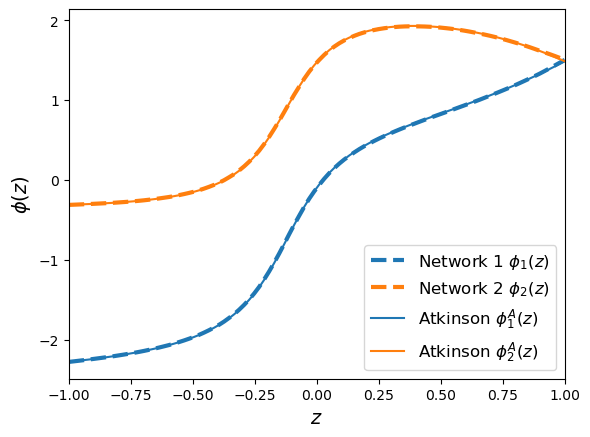

In [101]:
fig = plt.figure()
  
plt.plot(zpointseval.cpu(),phievals[0], '--', linewidth = 3)       
plt.plot(zpointseval.cpu(),phievals[1], '--', linewidth = 3)      
plt.plot(zpointseval.cpu(),np.angle(amp1), '-', linewidth = 1.5, color='tab:blue')      
plt.plot(zpointseval.cpu(),np.angle(amp2), '-', linewidth = 1.5, color='tab:orange')      
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$\phi(z)$', fontsize=14)    

plt.legend(['Network {} $\phi_{}(z)$'.format(i+1, i+1) for i in range(2)] + ['Atkinson $\phi_1^A(z)$','Atkinson $\phi_2^A(z)$'], fontsize=12)
plt.xlim([-1,1])
plt.show()

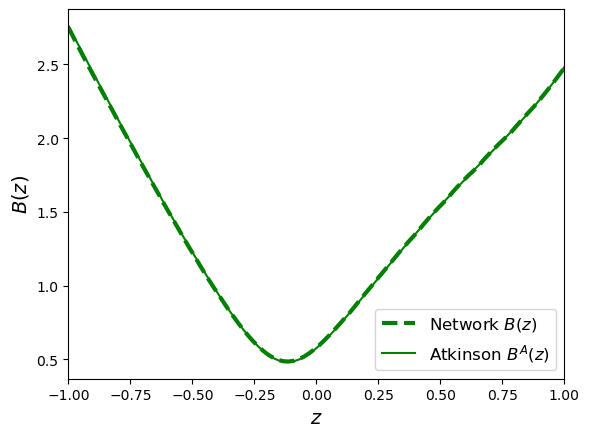

In [102]:
fig = plt.figure()
    
plt.plot(zpointseval.cpu(),modeval, '--', linewidth = 3, c='g')       
plt.plot(zpointseval.cpu(),np.abs(amp1), '-', linewidth = 1.5, c='g')  
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$B(z)$', fontsize=14)    

plt.legend(['Network $B(z)$'] + ['Atkinson $B^A(z)$'], fontsize=12)
plt.xlim([-1,1])
plt.show()

##### Use the pre-trained network to survey another part of the $z_1$ plane at $z_1=0.8+0.8i$

  0%|          | 0/5000 [00:00<?, ?epoch/s]

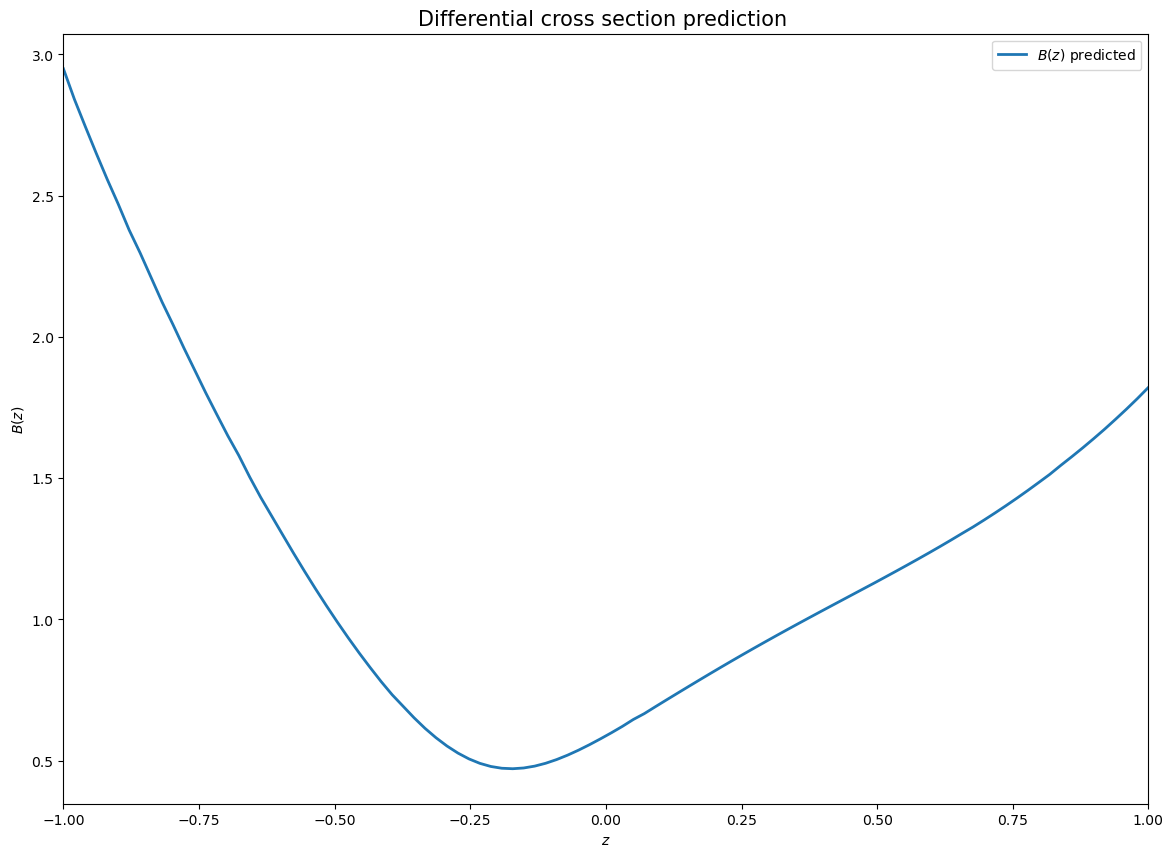

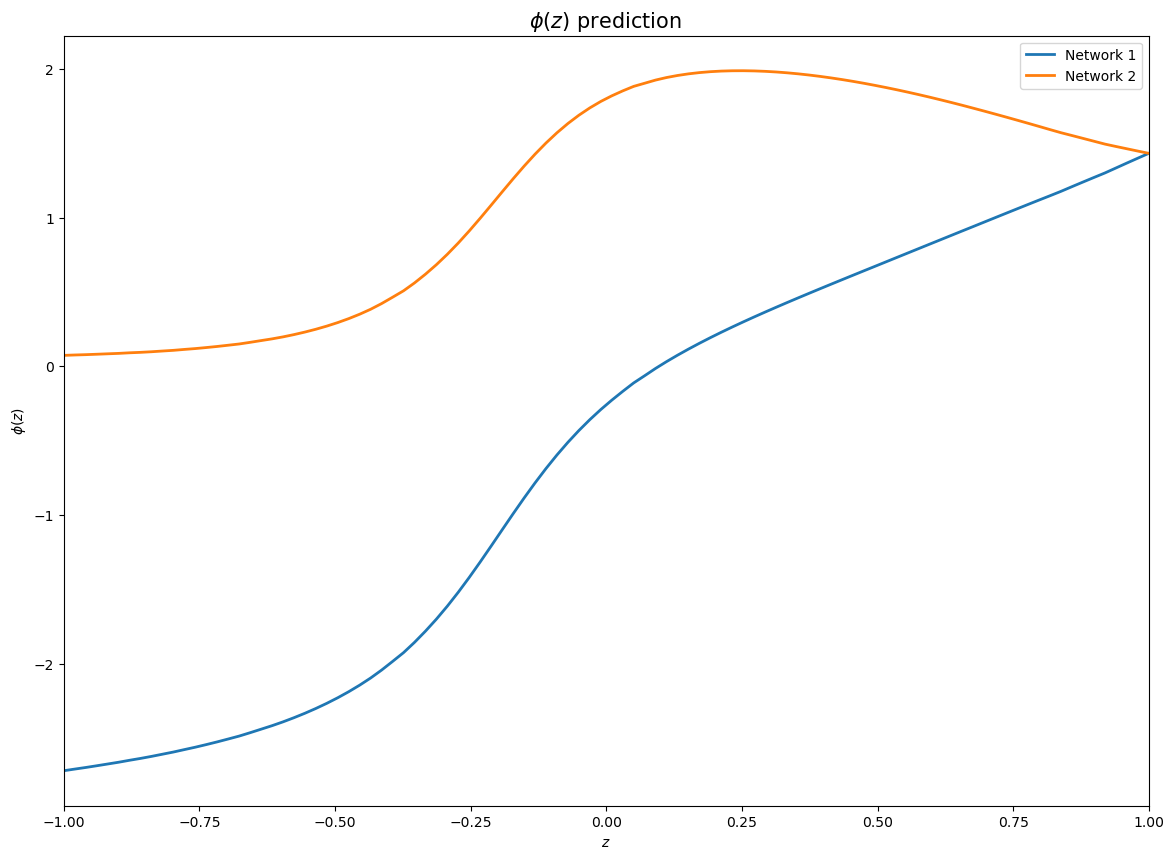

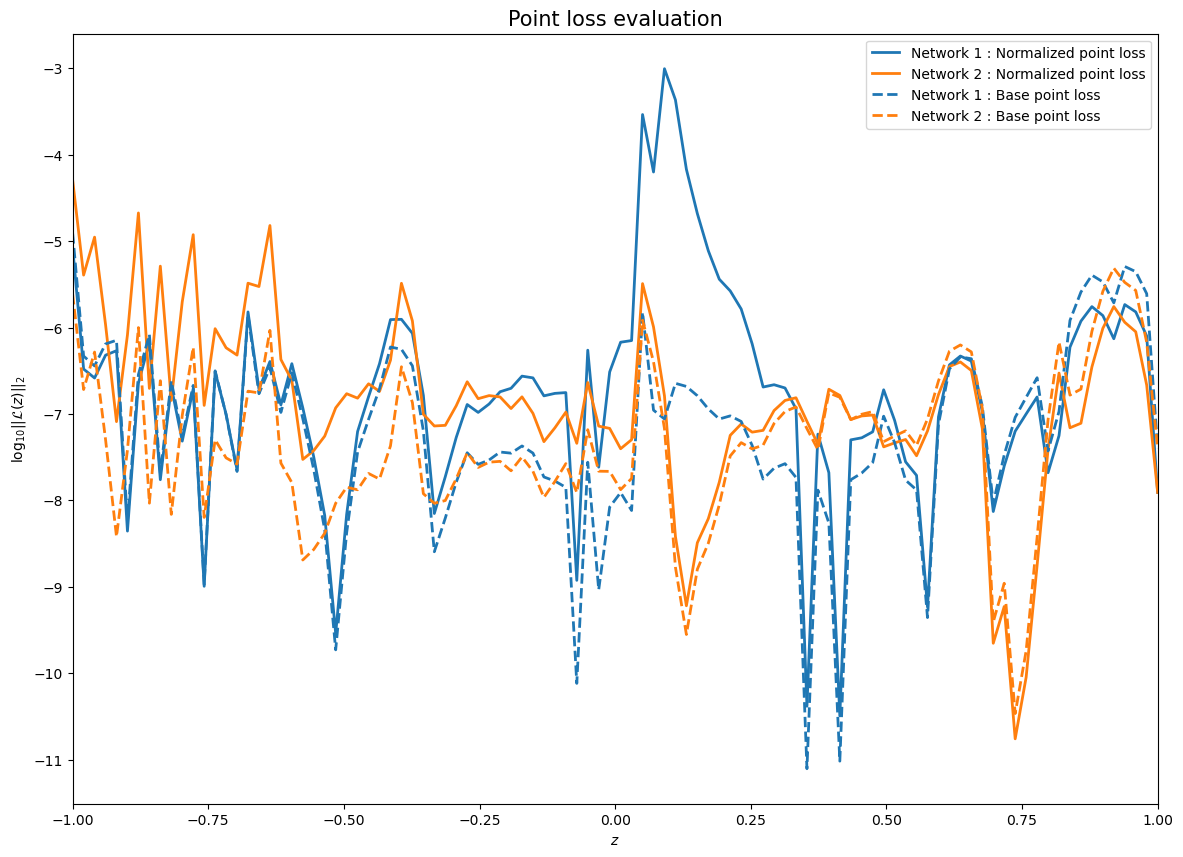

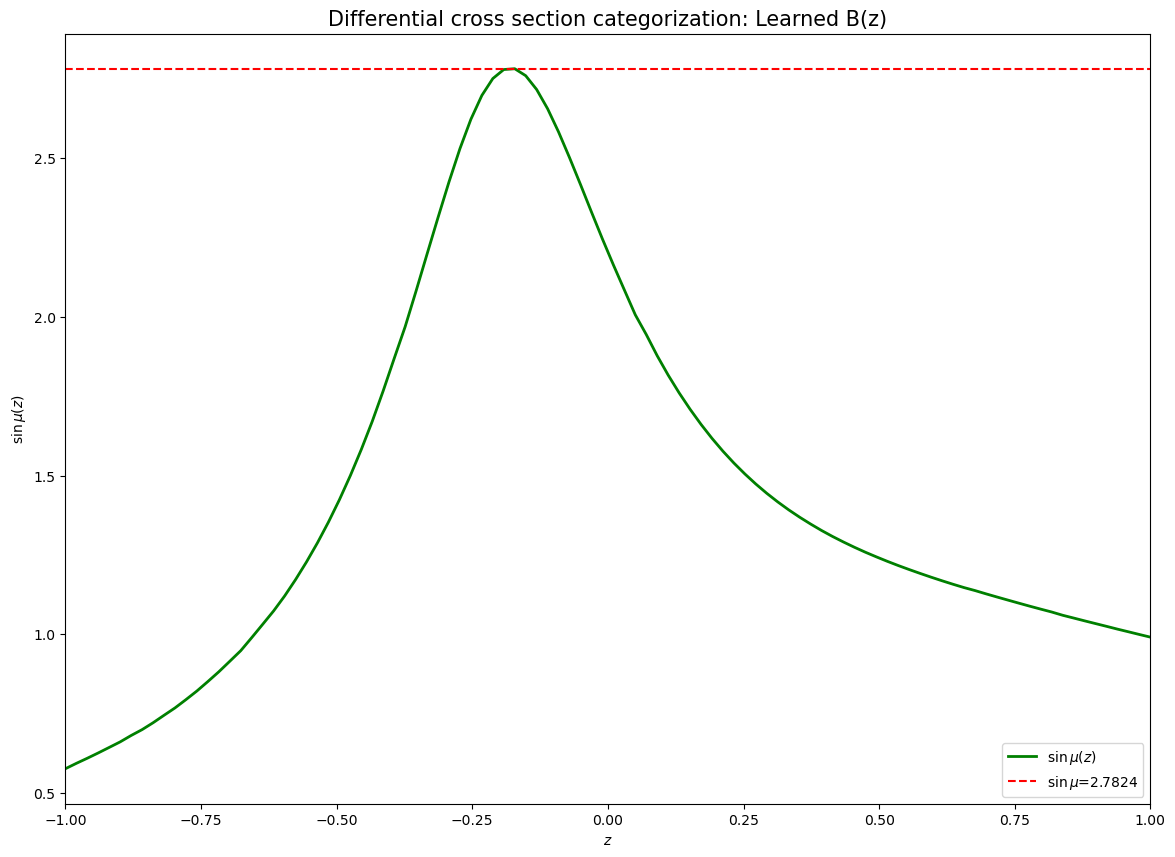

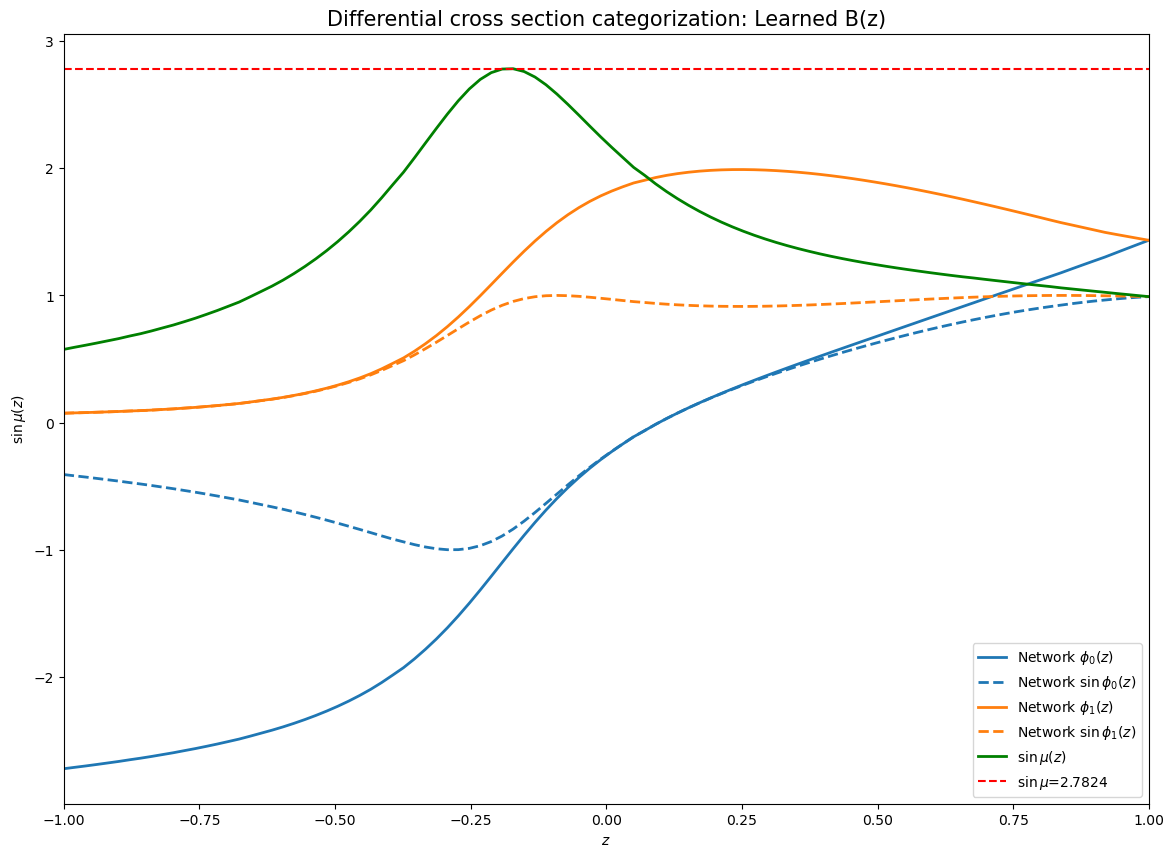

In [107]:
from copy import deepcopy

params2 = {'batch_size': 64,
         'epochs_num': 5000,
         'repulsive_epochs': [0, 1000],
         'learning_rate': 0.003,
         'lr_scheduler': True, 
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'layer_list': [64, 64, 64, 64],
         'loss': 'MSE',
         'scaled_loss': True,
         'zeros': [[0.8, 0.8]],
         'zeros_learn': False, 
         'zeros_freeze': True, 
         'disconnected': False,
         'complex_pred': True,
         'p_value': 2,
         'lambda_repulsive':1.0}
    
    
# Start from the same pretrained network
pre_trained_amps_z1=deepcopy(netsolver_fixed.amps_net)
pre_trained_amps_z1.zeros = params2['zeros']

netsolver_fixed2 = train_run(params2, device, seed_num=42, optim_name='Adam', amps_net=pre_trained_amps_z1)

zpointseval, modeval2, phievals2, eval_pt_loss_s2, eval_pt_loss_no_s2  = eval_run_amp(netsolver_fixed2, params2, device)

plot_bmod(zpointseval, modeval2)
plot_phases(zpointseval, phievals2)
plot_point_losses(zpointseval, eval_pt_loss_s2, eval_pt_loss_no_s2)

integralz2 = sin_mu_integral(netsolver_fixed2, zpointseval)
plot_sin_mu(zpointseval, integralz2)
plot_summaries(zpointseval, phievals2, integralz2)

#### Do a scan over the $z_1$ landscape

Now look to do an automatic scan over the $z_1$ plane. At each point we will log the loss along with the computed value of $\sin \mu$. Will first look at surveying the landscape using the same initialization. Then we will use a nearest neighbour initialization.

##### Evaluation and plotting routines

Evaluation routine

In [14]:
def eval_run_scan(trained_solver, params, device, steps_eval=100):
    """
    At evaluation we verify if the integral equation is satisfied. 
    For this we take a larger sample of z points
    """
    
    # Make sure we are in evaluation mode
    trained_solver.amps_net.eval()
    
    with torch.no_grad(): 
        
        # Create the evaluation points and compute the phase at those points
        zpointstest = torch.linspace(-1,1,steps=steps_eval, device=device)
                
        # Also log the final loss values. Including the loss at individual z values
        trained_solver.scaled_loss = True
        eval_loss_scaled = trained_solver.loss_function(zpointstest)
        
        trained_solver.scaled_loss = False
        eval_loss_base = trained_solver.loss_function(zpointstest)
        
        # Get the repulsive loss using the initial p_value
        trained_solver.p_value = params['p_value']
        repulsive_loss = trained_solver.dual_loss_ambiguity(zpointstest, multiple_out=True)
    return zpointstest, eval_loss_base, eval_loss_scaled, repulsive_loss

In [56]:
def simple_update_log(log_results, loss_threshold=0.0000316, repulsive_threshold=0.99):
    """
    Put a cut on the values of sin mu recovered to only display the ones associated with low loss
    and solutions that are not trivially ambiguous or identical
    """
    log_res_new = deepcopy(log_results)
    log_res_new['repulsive_loss_max'] = np.max(log_res_new['repulsive_loss'],axis=-1)
    mask_loss = log_res_new['scale_loss'] < loss_threshold
    mask_repulsive = log_res_new['repulsive_loss_max'] < repulsive_threshold
    
    sin_mu_cut = deepcopy(log_res_new['sinmu'])
    sin_mu_cut[~mask_loss] = np.nan
    sin_mu_cut[~mask_repulsive] = np.nan
    log_res_new['sinmucut'] = sin_mu_cut

    return log_res_new

Routines for plotting Atkinson's bounds

In [16]:
# Define Atkinson eq.3.24 and 3.12
def eqn1(x, y):
    return (x**2 + y**2 - 2*x)

def eqn1b(x, y):
    return (y - 1)

# Define Atkinson eq.3.21 and 3.13
def eqn2(x, y):
    return (x**2 + y**2 - 2*x+1)**(1/2)*(3/2)*(abs(1-x-y*1j)/abs(x+y*1j))*(abs(x+y*1j)-1/3)-abs(1-x-y*1j)
    #return (x**2+y**2-1)

def eqn2b(x, y):
    return (3*y/2)*(abs(1-x-y*1j)/abs(x+y*1j))*(abs(x+y*1j)-1/3)-abs(1-x-y*1j)

def eqncirc(x, y):
    return (x**2+y**2-1)
    

def plot_atkinson_bound():
    # Generate a grid of x and y values
    x = np.linspace(0, 2.1, 100)
    y = np.linspace(0, 1.1, 100)
    x1 = np.linspace(0, 1, 100)
    x2 = np.linspace(1, 2.1, 100)
    x3 = np.linspace(0, 1+(2/3)**(1/2), 100)
    X, Y = np.meshgrid(x, y)
    X1, Y = np.meshgrid(x1, y)
    X2, Y = np.meshgrid(x2, y)
    X3, Y = np.meshgrid(x1, y)

    # Evaluate the equation at each point on the grid
    Z1 = eqn1(X2, Y)
    Z1b = eqn1b(X1, Y)
    Z2 = eqn2(X2, Y)
    Z2b = eqn2b(X3, Y)
    Zcirc = eqncirc(X, Y)

    # Plot the solution curve
    plt.contour(X2, Y, Z1, levels=[0], colors='k')
    plt.contour(X1, Y, Z1b, levels=[0], colors='k')
    plt.contour(X2, Y, Z2, levels=[0], colors='tab:grey', linestyles='dashed')
    plt.contour(X3, Y, Z2b, levels=[0], colors='tab:grey', linestyles='dashed')
    plt.contour(X, Y, Zcirc, levels=[0], colors='k')

    # Add axis labels
    plt.xlabel('x')
    plt.ylabel('y')

Plotting the loss landscape

In [17]:
def plot_contour_loss_curves_linear(log_results, log_type='base10',  atkinson_bounds=False, max_l=-2):
    # Plot the log of the loss
    if log_type == 'base10':
        base_loss = np.transpose(np.log10(log_results['base_loss']))
        scale_loss = np.transpose(np.log10(log_results['scale_loss']))
    elif log_type == 'natural':
        base_loss = np.transpose(np.log(log_results['base_loss']))
        scale_loss = np.transpose(np.log(log_results['scale_loss']))
    else:
        raise NotImplemented
        
    sin_mu = np.transpose(log_results['sinmu'])
    sin_mu_cut = np.transpose(log_results['sinmucut'])
    
    min_x = min(log_results['params'][:,0])
    max_x = max(log_results['params'][:,0])
    min_y = min(log_results['params'][:,1])
    max_y = max(log_results['params'][:,1])
    
    fig = plt.figure(figsize=(14, 10))
    
    im1 = plt.imshow(base_loss, extent=[min_x,max_x,min_y,max_y], cmap='jet', vmax=max_l, origin='lower')       
    plt.xlabel('Re$[z]$')
    plt.ylabel('Im$[z]$')    
    plt.title('Base loss landscape in $z_1$ plane', fontsize = 15)
    cbar = plt.colorbar(im1,fraction=0.036)
    cbar.ax.set_title('$\log_{10} \mathcal{L}_E$', fontsize=16)
    if atkinson_bounds:
        plot_atkinson_bound()
    plt.show()
    plt.close(fig)
    
    fig2 = plt.figure(figsize=(14, 10))

    im2 = plt.imshow(scale_loss, extent=[min_x,max_x,min_y,max_y], cmap='jet', vmax=max_l, origin='lower') 
    plt.xlabel('Re$[z]$')
    plt.ylabel('Im$[z]$')    
    plt.title('Scaled loss landscape in $z_1$ plane', fontsize = 15)
    cbar = plt.colorbar(im2,fraction=0.036)
    cbar.ax.set_title('$\log_{10} \mathcal{L}_E^S$', fontsize=16)
    if atkinson_bounds:
        plot_atkinson_bound()
    plt.show()
    plt.close(fig2)
    
        
    fig3 = plt.figure(figsize=(14, 10))
    im3 = plt.imshow(sin_mu, extent=[min_x,max_x,min_y,max_y], cmap='jet', vmax=5.0, origin='lower') 

    plt.xlabel('Re$[z]$')
    plt.ylabel('Im$[z]$')    
    plt.title('$\sin \mu$ landscape in $z_1$ plane', fontsize = 15)
    cbar = plt.colorbar(im3,fraction=0.036)
    cbar.ax.set_title('$\sin \mu$', fontsize=16)
    if atkinson_bounds:
        plot_atkinson_bound()
    plt.show()
    plt.close(fig3)
    
    fig4 = plt.figure(figsize=(14, 10))
    im4 = plt.imshow(sin_mu_cut, extent=[min_x,max_x,min_y,max_y], cmap='jet', vmax=5.0, origin='lower')   
    plt.xlabel('Re$[z]$')
    plt.ylabel('Im$[z]$')    
    plt.title('$\sin \mu$ landscape in $z_1$ plane for small base loss values', fontsize = 15)
    cbar = plt.colorbar(im4,fraction=0.036)
    cbar.ax.set_title('$\sin \mu$', fontsize=16)
    if atkinson_bounds:
        plot_atkinson_bound()
    plt.show()
    plt.close(fig4)

##### Main Scan loop at fixed initialization. Will take on the order of a day to complete

Can load the data instead of running it to get the pictures

In [113]:
# Number of sampling points in both directions
num_x = 80
num_y = 40


# Prepare the grid of points
scan_range_x = np.linspace(0.01, 1.99, num=num_x)
scan_range_y = np.linspace(0.01, 0.99, num=num_y)
param_grid = np.dstack(np.meshgrid(scan_range_x, scan_range_y)).reshape(-1, 2)


log_res = {'params':param_grid, 'sinmu':np.empty([num_x, num_y]), 'base_loss':np.empty([num_x, num_y]), 'scale_loss':np.empty([num_x, num_y]), 'repulsive_loss':np.empty([num_x, num_y])}

for i, params_lin in enumerate(tqdm(param_grid, unit='grid_point')):
    
    x_index = i % num_x
    y_index = int((i - i % num_x)/num_x)

    params_scan = {'batch_size': 64,
             'epochs_num': 500,
             'repulsive_epochs': [0, 1000],
             'learning_rate': 0.003,
             'lr_scheduler': True, 
             'beta1' : 0.9,
             'beta2' : 0.999,
             'integral_points': 25,
             'method_int': 'trapz',
             'layer_list': [64, 64, 64, 64],
             'loss': 'MSE',
             'scaled_loss': True,
             'zeros': [[scan_range_x[x_index], scan_range_y[y_index]]],
             'zeros_learn': False, 
             'zeros_freeze': True, 
             'disconnected': False,
             'complex_pred': True,
             'p_value': 2,
             'lambda_repulsive': 0.0}
        
    # Start from the same pretrained network
    pre_trained_amps_z1=deepcopy(netsolver_fixed.amps_net)
    pre_trained_amps_z1.zeros = params_scan['zeros']
    
    sinmu_pt = []
    base_loss_pt = []
    scale_loss_pt = []
    repulsive_loss_pt = []
    
    netsolver = train_run(params_scan, device, seed_num=42, optim_name='Adam', amps_net=pre_trained_amps_z1)

    zpointseval, eval_loss_base, eval_loss_scaled, repulsive_loss = eval_run_scan(netsolver, params_scan, device)
    sinmu = max(sin_mu_integral(netsolver, zpointseval).cpu())
        
    log_res['sinmu'][x_index, y_index] = sinmu.cpu().numpy()
    log_res['base_loss'][x_index, y_index] = eval_loss_base.cpu().numpy()
    log_res['scale_loss'][x_index, y_index] = eval_loss_scaled.cpu().numpy()
    log_res['repulsive_loss'][x_index, y_index] = repulsive_loss.cpu().numpy()


  0%|          | 0/4 [00:00<?, ?grid_point/s]

  0%|          | 0/500 [00:00<?, ?epoch/s]

  0%|          | 0/500 [00:00<?, ?epoch/s]

  0%|          | 0/500 [00:00<?, ?epoch/s]

  0%|          | 0/500 [00:00<?, ?epoch/s]

##### Pictures at fixed initialization

In [55]:
load_results = True

if load_results:
    log_res= {'params':[], 'sinmu':[], 'base_loss':[], 'scale_loss':[], 'repulsive_loss':[]}

    path_load = 'Data/Atkinson_ML_Scans/Fixed_Initialization' ### PATH TO LOAD

    for key in log_res.keys():
        end_path = '.npy'
        path = path_load + str(key) + end_path
        array_data = np.load(path)
        log_res[key] = array_data

new_log= simple_update_log(log_res, loss_threshold=0.0000316, repulsive_threshold=0.99)

/var/folders/72/3_7s1hmx5b51pxyxq3_zkbxw0000gn/T/ipykernel_85775/3061417799.py:14: RuntimeWarning: divide by zero encountered in divide
  return (3*y/2)*(abs(1-x-y*1j)/abs(x+y*1j))*(abs(x+y*1j)-1/3)-abs(1-x-y*1j)
/var/folders/72/3_7s1hmx5b51pxyxq3_zkbxw0000gn/T/ipykernel_85775/3061417799.py:14: RuntimeWarning: invalid value encountered in multiply
  return (3*y/2)*(abs(1-x-y*1j)/abs(x+y*1j))*(abs(x+y*1j)-1/3)-abs(1-x-y*1j)


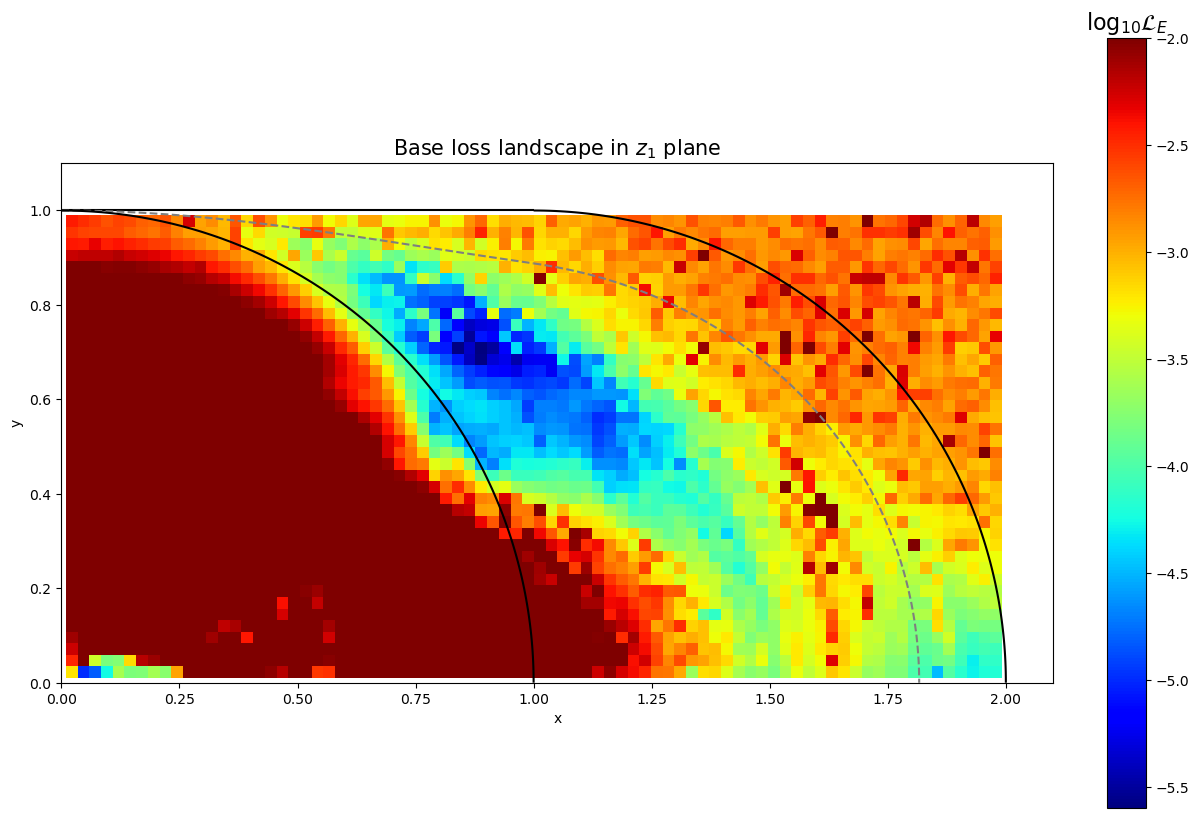

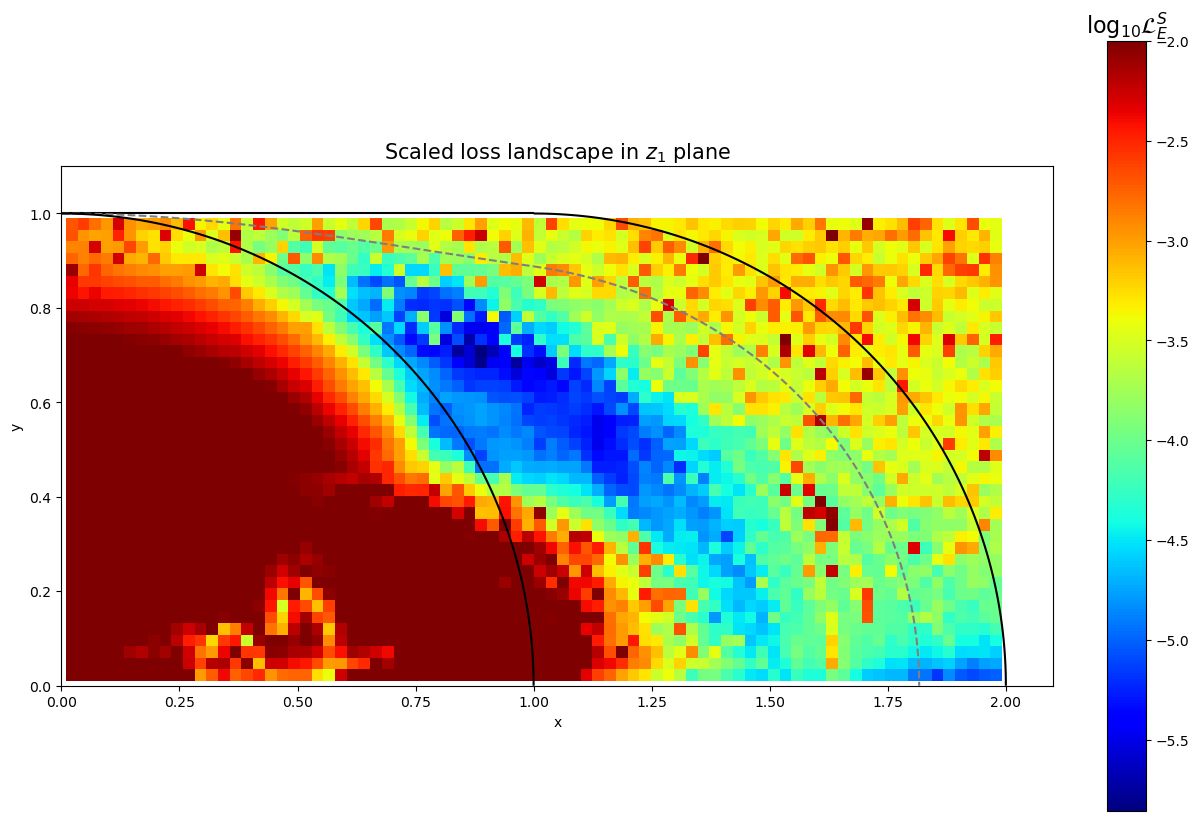

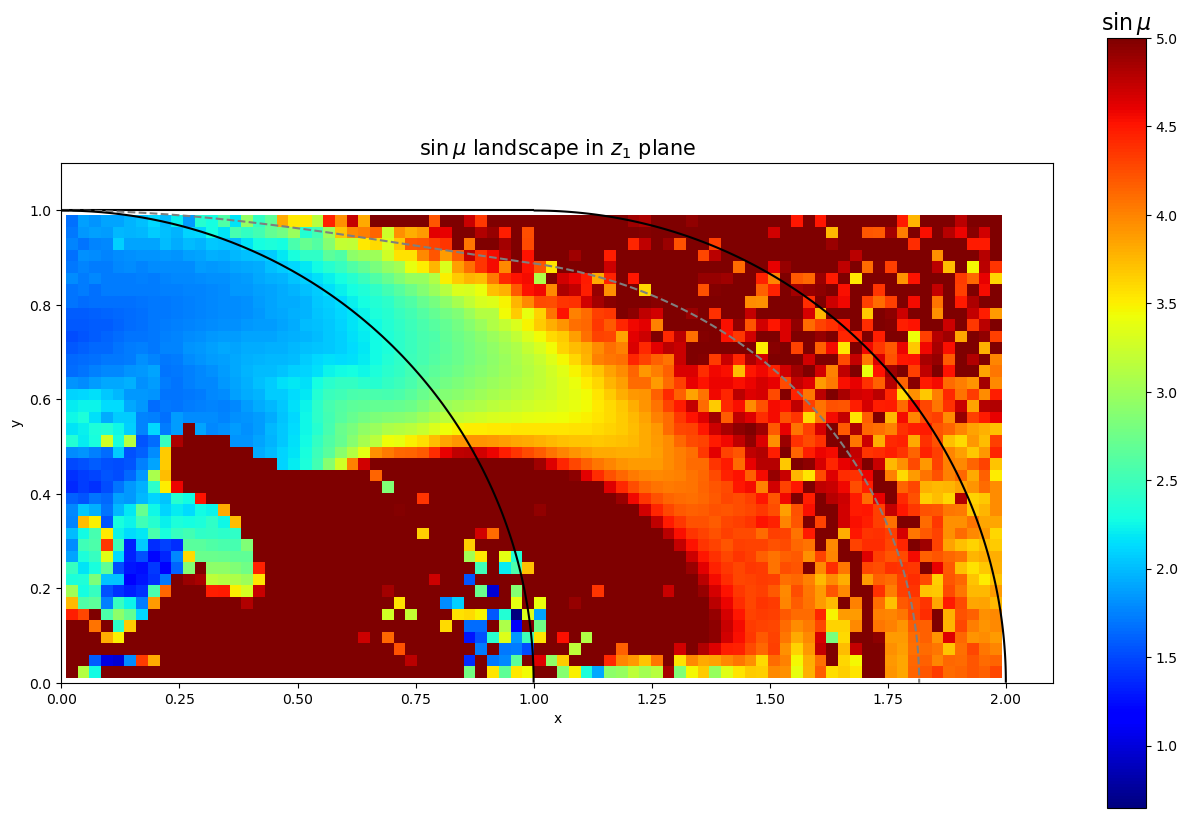

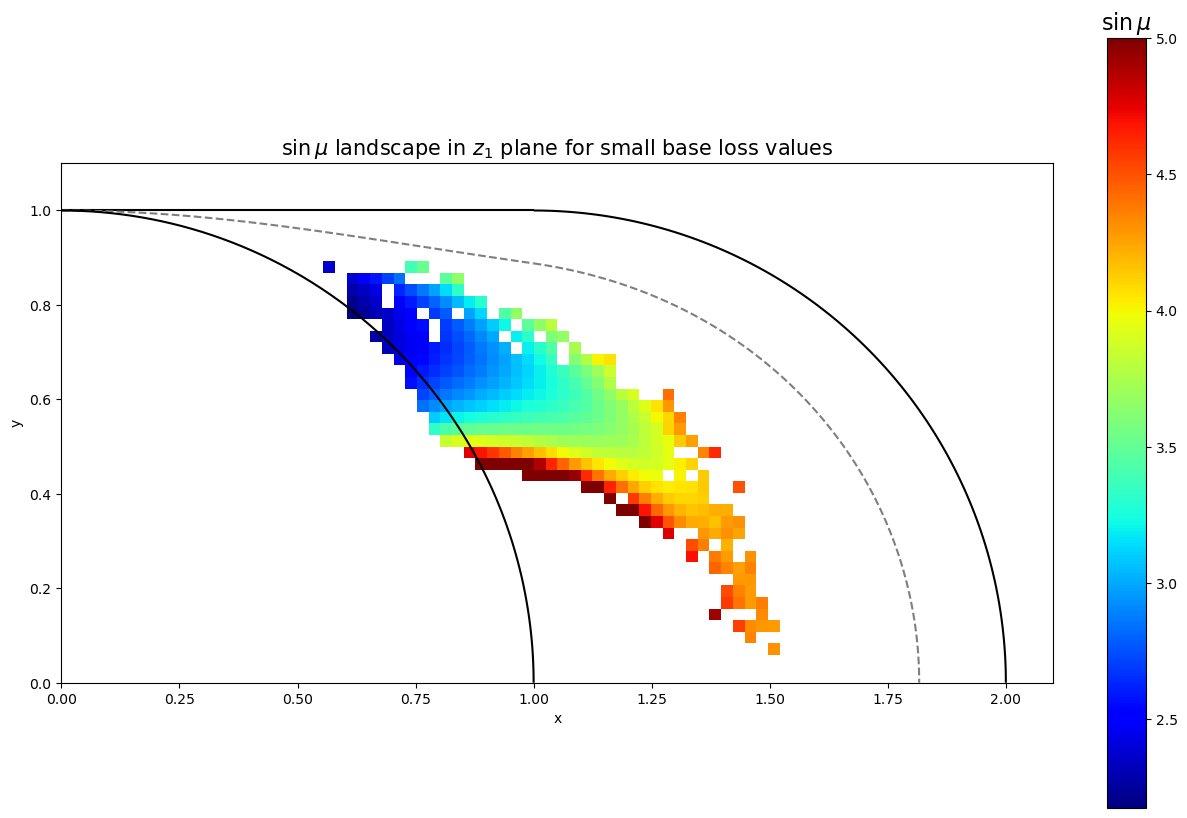

In [73]:
plot_contour_loss_curves_linear(new_log, log_type='base10', atkinson_bounds=True)

##### Neighbour Initialization

Routine for organizing the scan

In [58]:
import random 
from copy import deepcopy

def get_neighbour_networks(scan_nets, index_x, index_y):
    """
    Rountine for looking through the grid of trained neural networks and retaining a neibouring
    trained networks (if it exists). If we have multiple choices we return the one that had the lowest loss.
    """
    networks = scan_nets['Networks']
    losses = scan_nets['Min_loss']
    len_x = len(networks)
    len_y = len(networks[0])
    
    nn_indices = [[index_x+1,index_y], [index_x-1,index_y], [index_x,index_y-1], [index_x,index_y+1], [index_x,index_y]]
    nn_nets = []
    nn_loss = []
    for index_pair in nn_indices:
        if 0 <= index_pair[0] < len_x and 0 <= index_pair[1] < len_y:
            net_neighbour = networks[index_pair[0], index_pair[1]] 
            if net_neighbour is not None:
                nn_nets.append(net_neighbour)
                nn_loss.append(losses[index_pair[0], index_pair[1]] )
    
    return None if len(nn_nets) ==0 else nn_nets[np.argmin(np.array(nn_loss))]

In [59]:
# Number of sampling points in both directions
num_x = 80
num_y = 40

# Prepare the grid of points
scan_range_x = np.linspace(0.01, 1.99, num=num_x)
scan_range_y = np.linspace(0.01, 0.99, num=num_y)
param_grid = np.dstack(np.meshgrid(scan_range_x, scan_range_y)).reshape(-1, 2)


log_res_nn = {'params':param_grid, 'sinmu':np.empty([num_x, num_y]), 'base_loss':np.empty([num_x, num_y]), 'scale_loss':np.empty([num_x, num_y]), 'repulsive_loss':np.empty([num_x, num_y, 2])}
scan_nets = {'Evaluated':  np.zeros([num_x, num_y],dtype=bool), 'Networks': np.empty([num_x, num_y],dtype=object), 'Min_loss': np.empty([num_x, num_y])}

# Set the initial network point at which we start
# Point is at [1.2,0.6]
scan_nets['Networks'][int(num_x*1.2/2), int(num_y*0.6)] = deepcopy(netsolver_fixed.amps_net)

all_evaluated = False

pbar = tqdm(total = scan_nets['Evaluated'].size, unit='grid_point')

while not all_evaluated:

    for i, params_lin in enumerate(param_grid):

        x_index = i % num_x
        y_index = int((i - i % num_x)/num_x)
        
        # Grab the neighbouring initialized net if it exists
        net_nn = get_neighbour_networks(scan_nets, x_index, y_index)

        if not scan_nets['Evaluated'][x_index, y_index] and net_nn is not None:
        
            params_scan = {'batch_size': 64,
                     'epochs_num': 500,
                     'repulsive_epochs': [0, 1000],
                     'learning_rate': 0.003,
                     'lr_scheduler': True, 
                     'beta1' : 0.9,
                     'beta2' : 0.999,
                     'integral_points': 25,
                     'method_int': 'trapz',
                     'layer_list': [64, 64, 64, 64],
                     'loss': 'MSE',
                     'scaled_loss': True,
                     'zeros': [[scan_range_x[x_index], scan_range_y[y_index]]],
                     'zeros_learn': False, 
                     'zeros_freeze': True, 
                     'disconnected': False,
                     'complex_pred': True,
                     'p_value': 2,
                     'lambda_repulsive': 0.0}
            
            # Start from the same pretrained network
            pre_trained_amps_z1=deepcopy(net_nn)
            pre_trained_amps_z1.zeros = [[scan_range_x[x_index], scan_range_y[y_index]]]

            sinmu_pt = []
            base_loss_pt = []
            scale_loss_pt = []
            repulsive_loss_pt = []


            netsolver = train_run(params_scan, device, seed_num=42, optim_name='Adam', amps_net=pre_trained_amps_z1)

            zpointseval, eval_loss_base, eval_loss_scaled, repulsive_loss = eval_run_scan(netsolver, params_scan, device)
            sinmu = max(sin_mu_integral(netsolver, zpointseval).cpu())

            log_res_nn['sinmu'][x_index, y_index] = sinmu.cpu().numpy()
            log_res_nn['base_loss'][x_index, y_index] = eval_loss_base.cpu().numpy()
            log_res_nn['scale_loss'][x_index, y_index] = eval_loss_scaled.cpu().numpy()
            log_res_nn['repulsive_loss'][x_index, y_index,:] = np.array([r_loss.cpu().numpy() for r_loss in repulsive_loss])
            
            scan_nets['Evaluated'][x_index, y_index] = True
            scan_nets['Networks'][x_index, y_index] = deepcopy(netsolver.amps_net)
            scan_nets['Min_loss'][x_index, y_index] = sinmu.cpu().numpy()
            
            pbar.update(1)
            all_evaluated = scan_nets['Evaluated'].all()

  0%|          | 0/4 [00:00<?, ?grid_point/s]

  0%|          | 0/500 [00:00<?, ?epoch/s]

  0%|          | 0/500 [00:00<?, ?epoch/s]

  0%|          | 0/500 [00:00<?, ?epoch/s]

  0%|          | 0/500 [00:00<?, ?epoch/s]

##### Pictures for neighbour initialization

Load the results if required

In [71]:
load_results = True

if load_results:
    log_res_nn= {'params':[], 'sinmu':[], 'base_loss':[], 'scale_loss':[], 'repulsive_loss':[]}

    path_load = 'Data/Atkinson_ML_Scans/Neighbor_Initialization' ### PATH TO LOAD

    for key in log_res_nn.keys():
        end_path = '.npy'
        path = path_load + str(key) + end_path
        array_data = np.load(path)
        log_res_nn[key] = array_data

new_log_nn= simple_update_log(log_res_nn, loss_threshold=0.0000316, repulsive_threshold=0.99)

/var/folders/72/3_7s1hmx5b51pxyxq3_zkbxw0000gn/T/ipykernel_85775/3061417799.py:14: RuntimeWarning: divide by zero encountered in divide
  return (3*y/2)*(abs(1-x-y*1j)/abs(x+y*1j))*(abs(x+y*1j)-1/3)-abs(1-x-y*1j)
/var/folders/72/3_7s1hmx5b51pxyxq3_zkbxw0000gn/T/ipykernel_85775/3061417799.py:14: RuntimeWarning: invalid value encountered in multiply
  return (3*y/2)*(abs(1-x-y*1j)/abs(x+y*1j))*(abs(x+y*1j)-1/3)-abs(1-x-y*1j)


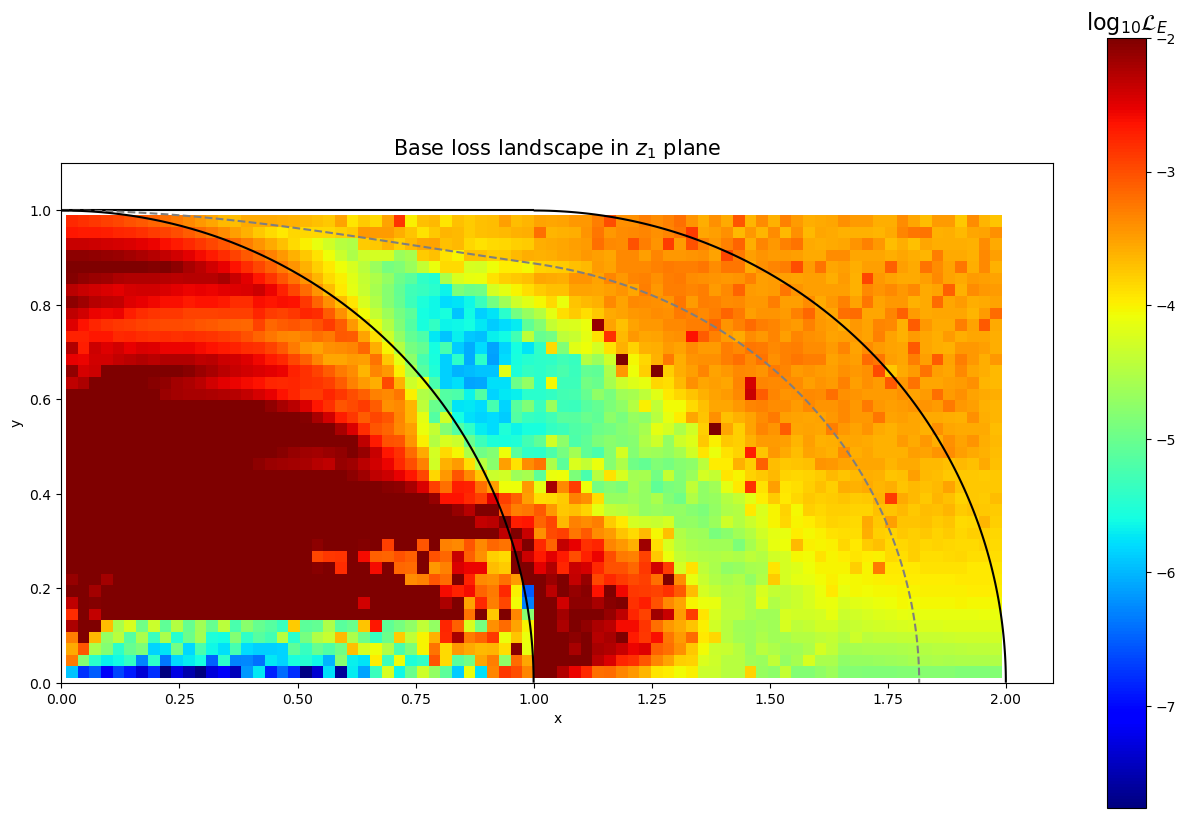

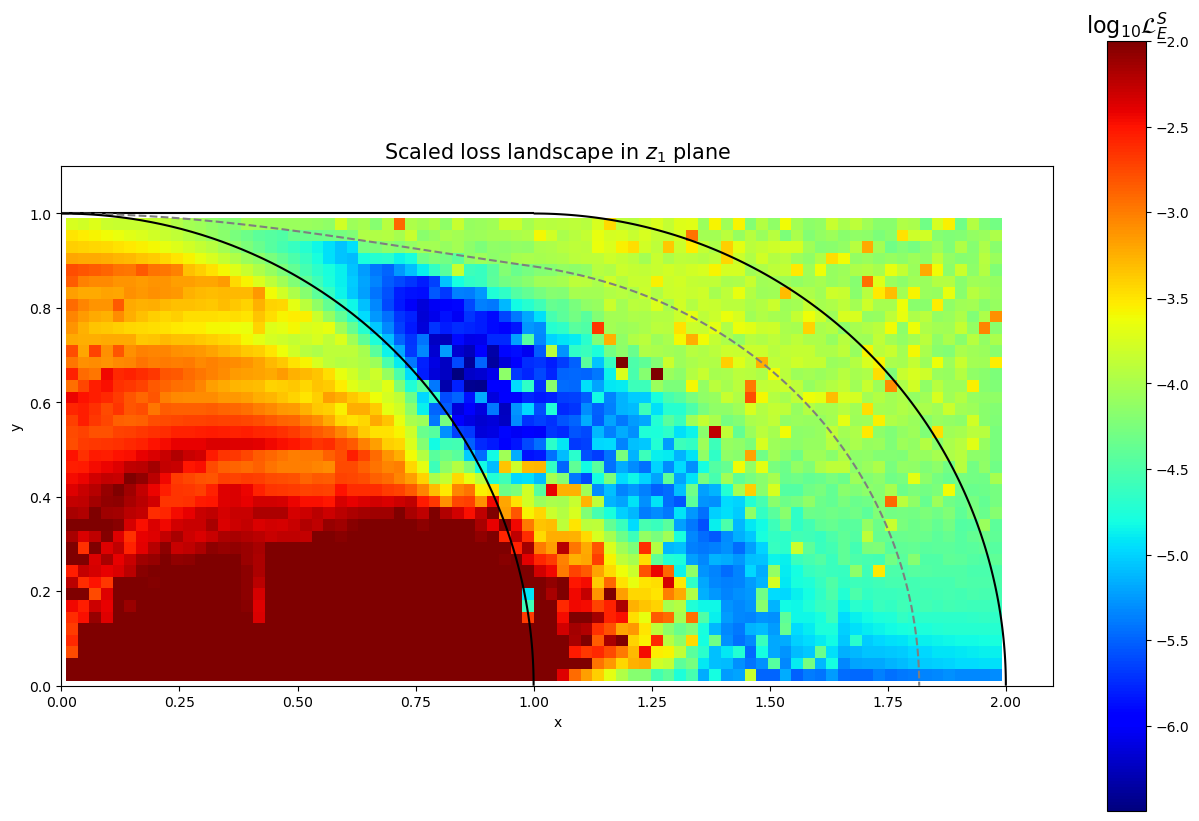

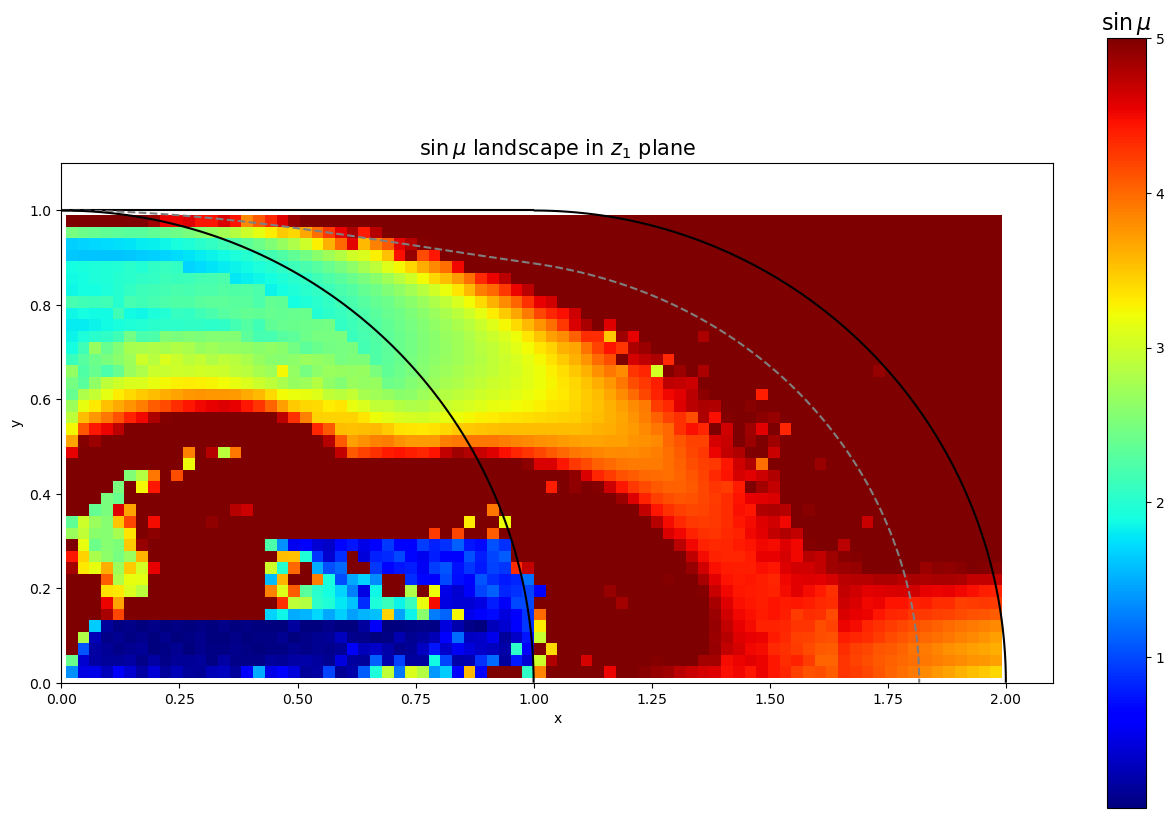

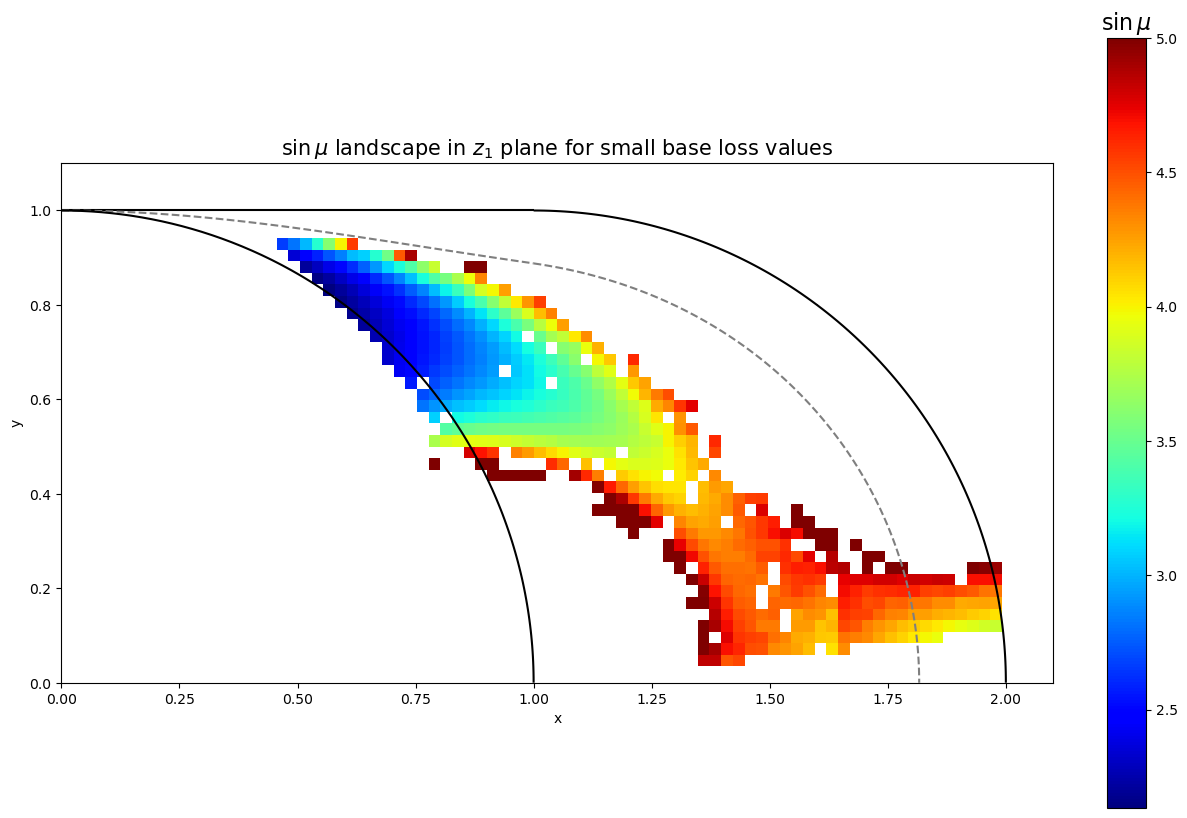

In [74]:
plot_contour_loss_curves_linear(new_log_nn, log_type='base10', atkinson_bounds=True)

#### Compare with the results from the descending algorithm and the polynomial amplitudes

##### Data imports

We can import the analytical results of polynomial amplitudes and of the descending algorithm to verify the structure of the loss landscape

Start by loading the regions of the descending algorithm

In [77]:
import csv

# Load the correct CSV files with the regions
data_regions_cut=[]

file_path = "Data/Atkinson_Classical/" #### Path to File

for i in range(5):
    file_region = open(file_path + "region{}newcut.csv".format(i+1), 'r')
    data_regions_cut.append(list(csv.reader(file_region, delimiter=',', quoting = csv.QUOTE_NONNUMERIC)))

Load the finite $L$ solutions

In [79]:
file_pathl= "Data/Finite_L_Class2"

# Load the correct CSV files with the (L=2) zeros
file_l2z1 = open(file_pathl + "z1.csv", 'r')
datal2z1 = list(csv.reader(file_l2z1, delimiter=',', quoting = csv.QUOTE_NONNUMERIC))
l2z1re, l2z1im = zip(*datal2z1[::23])

# Load the correct CSV files with the (L=3) class 2 zeros
file_l3z1a = open(file_pathl + "z1a.csv", 'r')
datal3z1a = list(csv.reader(file_l3z1a, delimiter=',', quoting = csv.QUOTE_NONNUMERIC))
l3z1are, l3z1aim = zip(*datal3z1a[4:-1][::3])

##### Plots

/var/folders/72/3_7s1hmx5b51pxyxq3_zkbxw0000gn/T/ipykernel_85775/3061417799.py:14: RuntimeWarning: divide by zero encountered in divide
  return (3*y/2)*(abs(1-x-y*1j)/abs(x+y*1j))*(abs(x+y*1j)-1/3)-abs(1-x-y*1j)
/var/folders/72/3_7s1hmx5b51pxyxq3_zkbxw0000gn/T/ipykernel_85775/3061417799.py:14: RuntimeWarning: invalid value encountered in multiply
  return (3*y/2)*(abs(1-x-y*1j)/abs(x+y*1j))*(abs(x+y*1j)-1/3)-abs(1-x-y*1j)


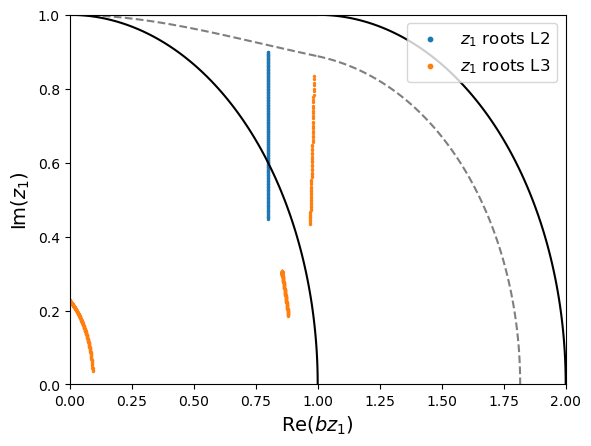

In [81]:
fig = plt.figure()

plt.scatter(l2z1re,l2z1im, s=2)
plt.scatter(l3z1are,l3z1aim, s=2)
legend = plt.legend(['$z_1$ roots L2', '$z_1$ roots L3'], fontsize=12)
for i in range(len(legend.legendHandles)):
    legend.legendHandles[i]._sizes = [10]

plot_atkinson_bound()
plt.xlabel('Re$(bz_1)$', fontsize=14)
plt.ylabel('Im$(z_1)$', fontsize=14) 
plt.xlim([0,2])
plt.ylim([0,1])
plt.show()

First figure where we look at all regions potentially

Make a new figure where we only include the cut points

/var/folders/72/3_7s1hmx5b51pxyxq3_zkbxw0000gn/T/ipykernel_85775/3061417799.py:14: RuntimeWarning: divide by zero encountered in divide
  return (3*y/2)*(abs(1-x-y*1j)/abs(x+y*1j))*(abs(x+y*1j)-1/3)-abs(1-x-y*1j)
/var/folders/72/3_7s1hmx5b51pxyxq3_zkbxw0000gn/T/ipykernel_85775/3061417799.py:14: RuntimeWarning: invalid value encountered in multiply
  return (3*y/2)*(abs(1-x-y*1j)/abs(x+y*1j))*(abs(x+y*1j)-1/3)-abs(1-x-y*1j)


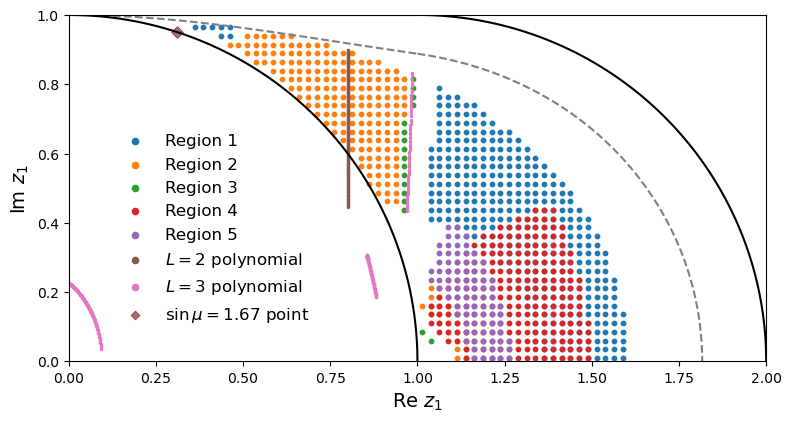

In [82]:
fig = plt.figure(figsize=(9,4.5))

# Plot the regions
for i in range(5):
    plt.scatter(np.array(data_regions_cut[i])[:,0], np.array(data_regions_cut[i])[:,1], s=10, alpha=1.0, edgecolors='face')

# Plot the finite L solutions
plt.scatter(l2z1re,l2z1im, s=2)
plt.scatter(l3z1are,l3z1aim, s=2)

# Plot the minimal sin mu solution recovered
plt.scatter(np.real(1.001*np.exp(1j*0.4*math.pi)),np.imag(1.001*np.exp(1j*0.4*math.pi)),marker="D",edgecolors='r',linewidth=0.5)

plot_atkinson_bound()

plt.xlim([0,2])
plt.ylim([0,1])
plt.xlabel('Re $z_1$', fontsize=14)
plt.ylabel('Im $z_1$', fontsize=14) 
lgnd = plt.legend(['Region 1','Region 2','Region 3','Region 4','Region 5','$L=2$ polynomial', '$L=3$ polynomial' ,'$\sin \mu = 1.67$ point'], fontsize=12, frameon=False,  bbox_to_anchor=(0.05, 0.7))
for handle in lgnd.legendHandles:
    handle.set_sizes([20.0])

plt.show()

### Studying the gradients of $\sin \mu$ in $z_1$ landscape

#### Gradient descent implementation

Routine for calculating the gradient

In [47]:
def calculate_grad(params, epsilon, zeros_start, sinmustart, style, base_net, seed=42, dim=0, zero_num=0):
    """
    Calculate the sin mu gradient in a given direction
    Can use forward, backward or central difference 
    At each new point we retrain a network and calculate the corresponding sin mu values
    """
    zero_1 = deepcopy(zeros_start[zero_num])
    zero_2 = deepcopy(zeros_start[zero_num])

    if style == 'central':
        zero_1[dim] = zero_1[dim] + epsilon
        zero_2[dim] = zero_2[dim] - epsilon
        factor = 2 * epsilon

    if style == 'forward':
        zero_1[dim] = zero_1[dim] + epsilon
        zero_2 = 'Calculated'
        factor = epsilon

    if style == 'backward':
        zero_1 = 'Calculated'
        zero_2[dim] = zero_2[dim] - epsilon
        factor = epsilon

    sinmus = []

    for zero in [zero_1, zero_2]:

        if zero == 'Calculated':
            sinmus.append(sinmustart)
        else:
            pre_trained_amps_z1 = deepcopy(base_net)

            pre_trained_amps_z1.zeros = zeros_start[:zero_num] + [zero] + zeros_start[zero_num + 1:]
            netsolver = train_run(params, base_net.device, seed_num=seed, amps_net=pre_trained_amps_z1)
            zpointseval = torch.linspace(-1, 1, steps=100, device=base_net.device)
            sinmu = max(sin_mu_integral(netsolver, zpointseval).cpu())
            sinmus.append(sinmu)

    return (sinmus[0] - sinmus[1]) / factor

#### Pretrain at $z_1 = 1.0+0.5i$

In [84]:
init_zeros = [[1.0, 0.5]]

params = {'batch_size': 64,
         'epochs_num': 5000,
         'repulsive_epochs': [0, 1000],
         'learning_rate': 0.003,
         'lr_scheduler': True, 
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'layer_list': [64, 64, 64, 64],
         'loss': 'MSE',
         'scaled_loss': True,
         'zeros': init_zeros
         'disconnected': False,
         'complex_pred': True,
         'p_value': 2,
         'lambda_repulsive':2.0}

network_fixed2 = deepcopy(netsolver_fixed.amps_net)
network_fixed2.zeros = init_zeros

netsolver_fixed2 = train_run(params, device, seed_num=42, optim_name='Adam', amps_net=network_fixed2)

  0%|          | 0/5000 [00:00<?, ?epoch/s]

In [87]:
zpointseval2, _, _, _, _, eval_scale2, eval_base2 = eval_run_amp(netsolver_fixed2, params, device)
integralz2 = sin_mu_integral(netsolver_fixed2, zpointseval2)
sinmu_l32 = max(integralz2.cpu())

#### Do the gradient descent starting from the pretrained point

Can also load results below

Prepare the parameters

In [97]:
# Prepare the overall parameters
params_scan = deepcopy(params)
params_scan['epochs_num'] = 500
params_scan['zeros'] = init_zeros
params_scan['lambda_repulsive'] = 0.0

# Prepare the loggers 
log_sinmu_scan = {'points_visit': [init_zeros], 'sinmu': [], 'gradients': [], 'networks': [], 'loss_base': [],
                  'loss_scale': []}


# Get the initial stats
init_net = deepcopy(netsolver_fixed2.amps_net)
init_sinmu = sinmu_l32
log_sinmu_scan['loss_base'].append(eval_base2)
log_sinmu_scan['loss_scale'].append(eval_scale2)
log_sinmu_scan['sinmu'].append(init_sinmu)
log_sinmu_scan['networks'].append(init_net)

# Prepare the parameters for the finite difference
epsilon = 0.001
lr = 0.005
style = 'central'
max_pts = 150
small_grad = False

Do the gradient descent

In [98]:
# Loop while we have a large gradient or we have not exceeded the budget
while not small_grad and len(log_sinmu_scan['points_visit']) < max_pts:

    # Calculate the gradient
    grad_x = calculate_grad(params_scan, epsilon, init_zeros, init_sinmu, style, init_net,
                             seed=42, dim=0, zero_num=0)
    grad_y = calculate_grad(params_scan, epsilon, init_zeros, init_sinmu, style, init_net,
                             seed=42, dim=1, zero_num=0)
    log_sinmu_scan['gradients'].append([[grad_x, grad_y]])

    small_grad = (grad_x ** 2 + grad_y ** 2) < 0.01

    # Update the value of the zero location (put some cutoff on the gradient)
    new_zero_x = init_zeros[0][0] - lr * min(abs(grad_x), 5) * grad_x / abs(grad_x)
    new_zero_y = init_zeros[0][1] - lr * min(abs(grad_y), 5) * grad_y / abs(grad_y)
    init_zeros = [[new_zero_x, new_zero_y]]
    norm_zero = np.sqrt(new_zero_x**2 + new_zero_y**2)

    # Check that we stay out of unit circle, if not we project out by a bit more
    if norm_zero < 1:
          init_zeros = [[new_zero_x*(1.01)/norm_zero, new_zero_y*(1.01)/norm_zero]]
            
    params_scan['zeros'] = init_zeros

    # Update the new initial net and train it at that point
    init_net = deepcopy(init_net)
    init_net.zeros = init_zeros
    netsolver = train_run(params_scan, device, seed_num=42, optim_name='Adam', amps_net=init_net)

    zpointseval, _, _, _, _, eval_loss_scaled, eval_loss_base = eval_run_amp(netsolver, params_scan, device, steps_eval=100, num=None)
    init_sinmu = max(sin_mu_integral(netsolver, zpointseval).cpu())
    
    # Save the statistics along with the trained networks along the trajectory
    log_sinmu_scan['points_visit'].append(init_zeros)
    log_sinmu_scan['loss_base'].append(eval_loss_base)
    log_sinmu_scan['loss_scale'].append(eval_loss_scaled)
    log_sinmu_scan['sinmu'].append(init_sinmu)
    log_sinmu_scan['networks'].append(deepcopy(init_net))

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/50 [00:00<?, ?epoch/s]

#### Plot the results of the trajectory

Load the results if necessary

In [101]:
load_results = True

if load_results:
    path_init = 'Data/Gradient_descent/traj_1_' ### PATH
    log_sinmuscan_tot = {'points_visit':[], 'sinmu': [], 'gradients':[], 'networks':[], 'loss_base':[], 'loss_scale':[]}
    num_pts_load = 150

    for key in log_sinmuscan_tot.keys():
        if key != 'networks':
            end_path = '_gradient.npy'
            path = path_init  + str(key) + end_path 
            array_data = np.load(path) 
            log_sinmuscan_tot[key] = array_data

Recover the lowest $\sin \mu$ value and its location

In [106]:
print(min(log_sinmuscan_tot['sinmu']))
print(np.argmin(log_sinmuscan_tot['sinmu']))
print(log_sinmuscan_tot['points_visit'][141])

1.985067
141
[[0.39700693 0.92870098]]


Plot the evolution of $\sin \mu$ and the loss 

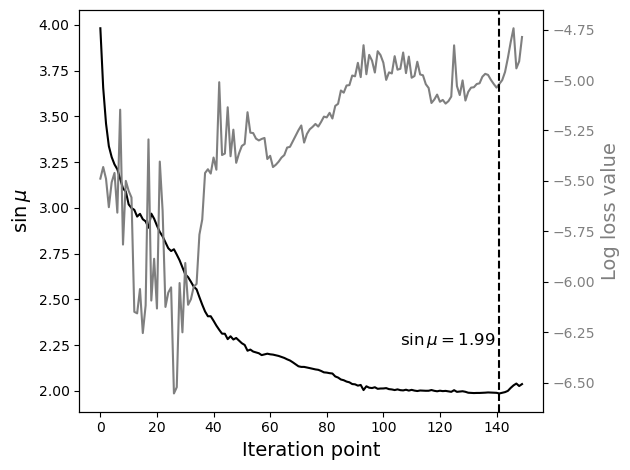

In [105]:
cutoff = np.argmin(log_sinmuscan_tot['sinmu'])

fig, ax1 = plt.subplots()
ax1.set_xlabel('Iteration point', fontsize =14)
ax1.set_ylabel('$\sin \mu$', color='black', fontsize =14)
ax1.plot(log_sinmuscan_tot['sinmu'][0:150], color='black')
ax1.tick_params(axis='y', labelcolor='black')
plt.text(cutoff-35, 2.25, '$\sin \mu = 1.99$', fontsize=12)

ax2 = ax1.twinx()  
ax2.set_ylabel('Log loss value', color='tab:grey', fontsize =14)  
ax2.plot(np.log10(log_sinmuscan_tot['loss_scale'][0:150]), color='tab:grey')
ax2.tick_params(axis='y', labelcolor='tab:grey')

plt.axvline(x = cutoff, color = 'k', linestyle='--')
fig.tight_layout()  
plt.show()

Plot the evolution of the $z_1$ root

In [108]:
points1 = log_sinmuscan_tot['points_visit'][0:cutoff,0]

utemp1 = np.diff(points1[:,0])
vtemp1 = np.diff(points1[:,1])

pos_ar_x1 = points1[:,0][:-1] + utemp1/2
pos_ar_y1 = points1[:,1][:-1] + vtemp1/2
normtemp1 = np.sqrt(utemp1**2+vtemp1**2) 

/var/folders/72/3_7s1hmx5b51pxyxq3_zkbxw0000gn/T/ipykernel_85775/3061417799.py:14: RuntimeWarning: divide by zero encountered in divide
  return (3*y/2)*(abs(1-x-y*1j)/abs(x+y*1j))*(abs(x+y*1j)-1/3)-abs(1-x-y*1j)
/var/folders/72/3_7s1hmx5b51pxyxq3_zkbxw0000gn/T/ipykernel_85775/3061417799.py:14: RuntimeWarning: invalid value encountered in multiply
  return (3*y/2)*(abs(1-x-y*1j)/abs(x+y*1j))*(abs(x+y*1j)-1/3)-abs(1-x-y*1j)


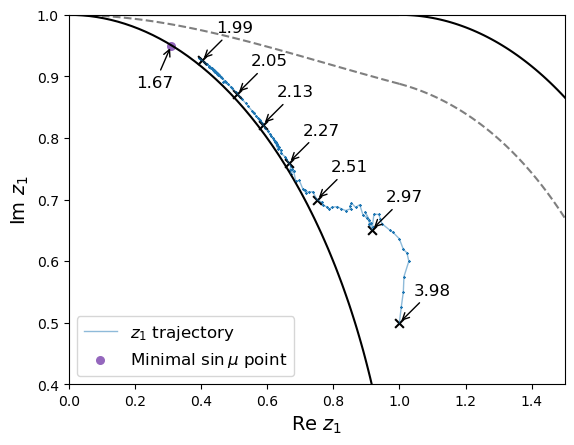

In [111]:
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

min_point_mu = [0.31, 0.95]

indices = [0, int(len(points1)*0.1), int(len(points1)*0.25), int(len(points1)*0.35), int(len(points1)*0.5), int(len(points1)*0.62) ,-1]
color_r = cm.rainbow(np.linspace(0, 1, len(indices)))

sinmus = [log_sinmuscan_tot['sinmu'][:cutoff][i] for i in indices]

fig = plt.figure()

plot_atkinson_bound()

plt.plot(points1[:, 0], points1[:, 1],color='tab:blue', linewidth=1, alpha=0.5)
plt.scatter(points1[:, 0], points1[:, 1],s=1, marker='x', color='tab:blue', label='_nolegend_')
for i, ind in enumerate(indices):
    plt.scatter(points1[ind, 0], points1[ind, 1],s=40, color='k',marker='x', label='_nolegend_')
    plt.annotate(str(round(sinmus[i],2)), xy=(points1[ind, 0], points1[ind, 1]), xycoords='data', xytext=(10,20), textcoords='offset points',arrowprops=dict(arrowstyle="->"), fontsize=12)

plt.scatter(min_point_mu[0], min_point_mu[1], s=30, c='tab:purple')
plt.annotate('1.67', xy=(min_point_mu[0], min_point_mu[1]), xycoords='data', xytext=(-25,-30), textcoords='offset points',arrowprops=dict(arrowstyle="->"), fontsize=12)

plt.legend(['$z_1$ trajectory'] + ['Minimal $\sin \mu$ point'], loc='lower left', fontsize=12)
plt.xlim([0,1.5])
plt.ylim([0.4,1])
plt.xlabel('Re $z_1$', fontsize=14)
plt.ylabel('Im $z_1$', fontsize=14) 
plt.show()



### Resolve now when taking out multiple zeros

#### Recover a single solution

##### Solve when taking out $z_1,z_2$ roots to reproduce an $L=3$ solution. Start with a pretrained net

  0%|          | 0/5000 [00:00<?, ?epoch/s]

  0%|          | 0/5000 [00:00<?, ?epoch/s]

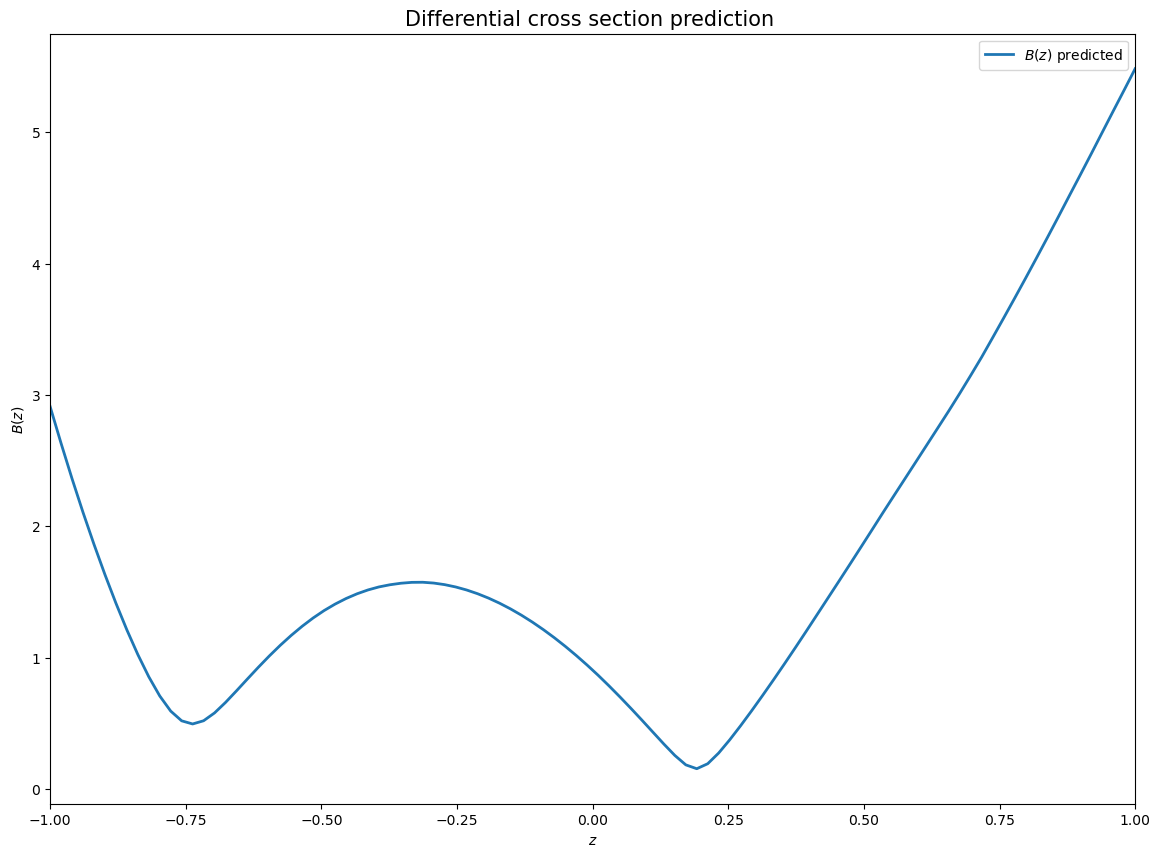

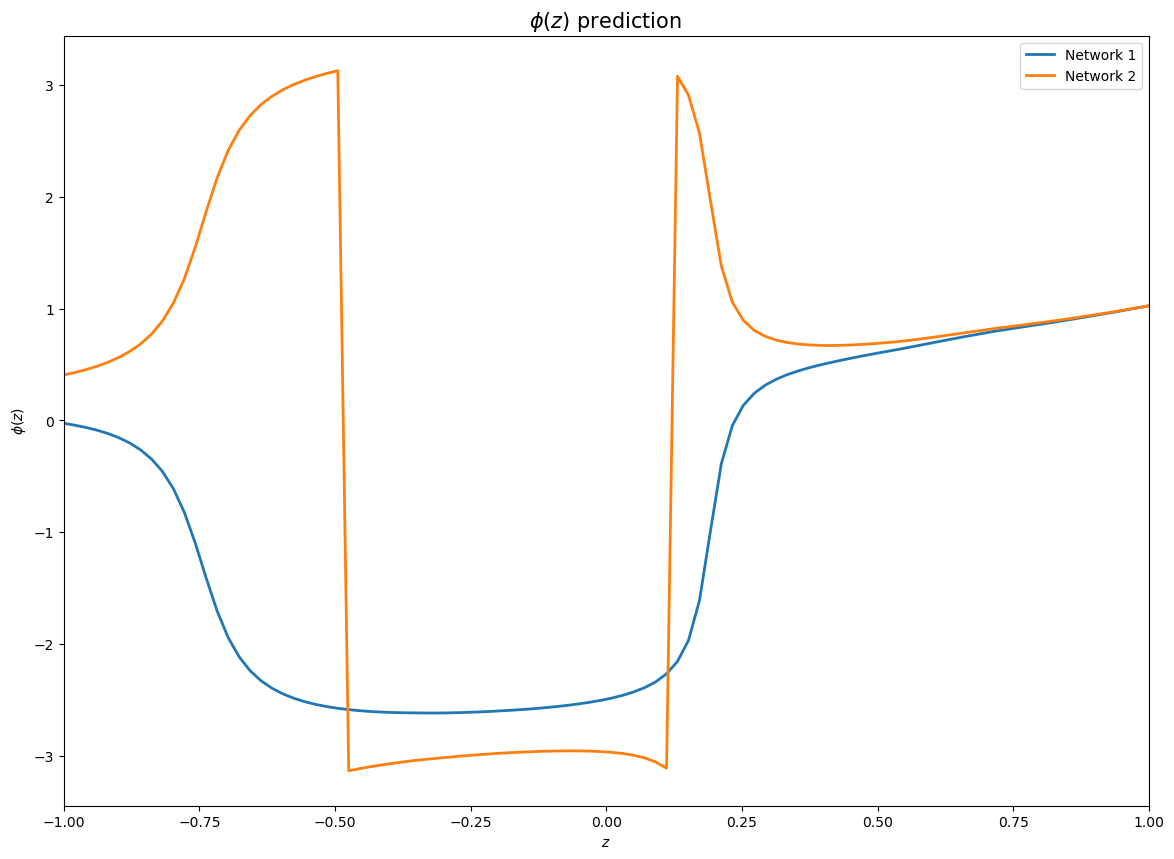

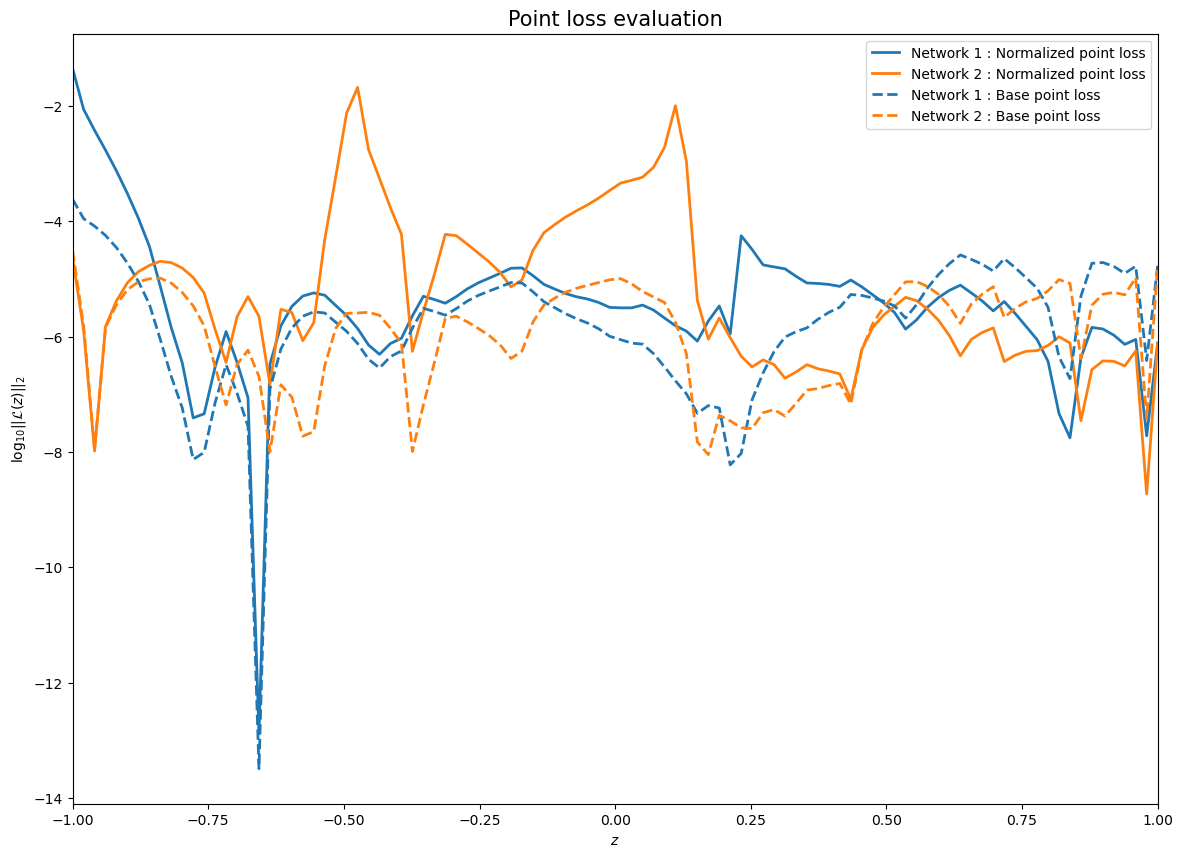

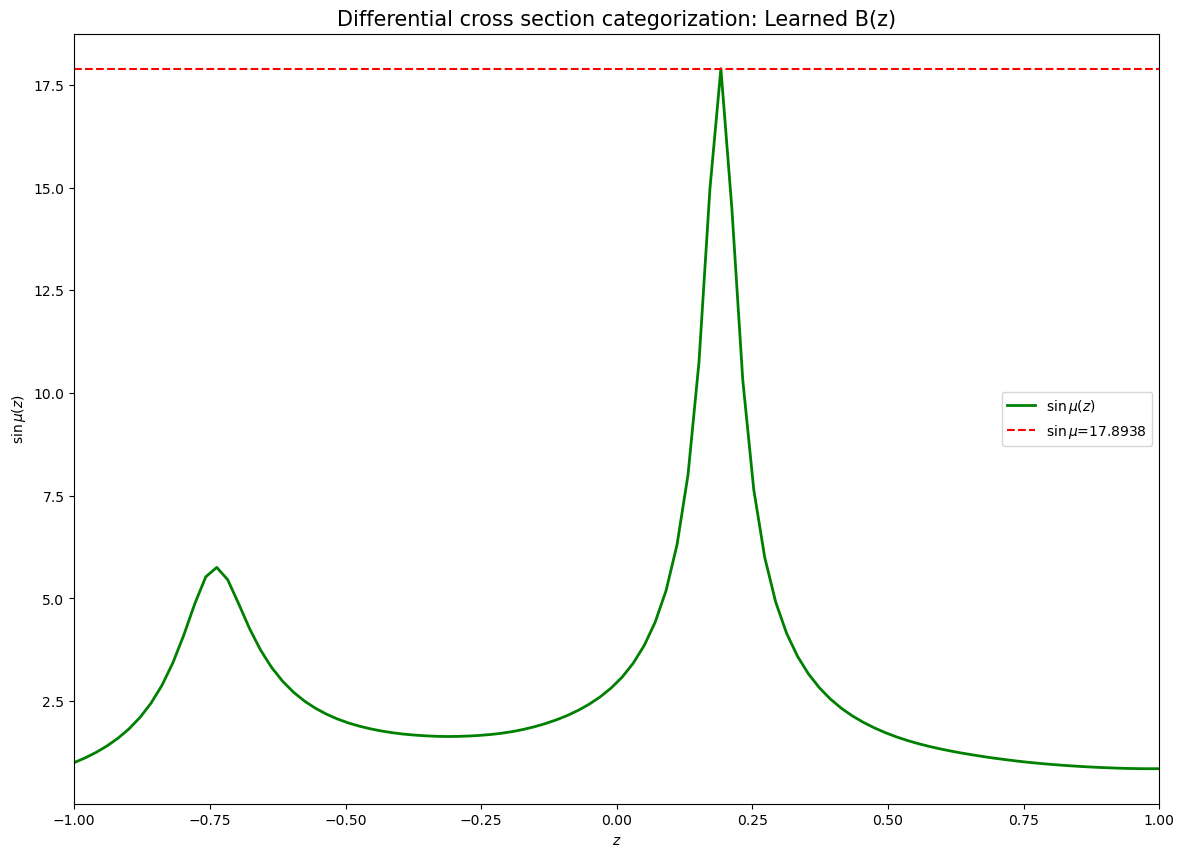

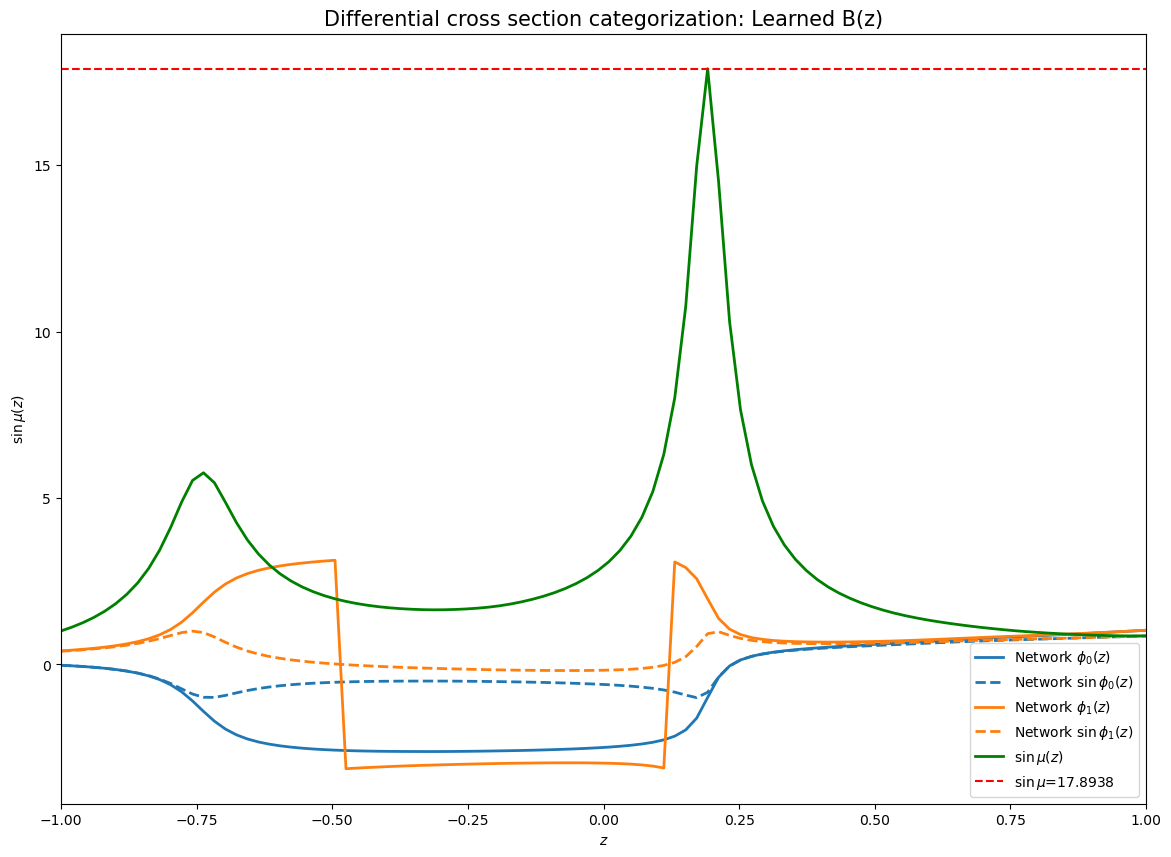

In [51]:
# Put on CPU as later we take complex numbers (MPS will not support)

device = torch.device('cpu')

params = {'batch_size': 64,
         'epochs_num': 5000,
         'repulsive_epochs': [0, 1000],
         'learning_rate': 0.003,
         'lr_scheduler': True, 
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'layer_list': [64, 64, 64, 64],
         'loss': 'MSE',
         'scaled_loss': True,
         'zeros': [[1.2, 0.6]],
         'disconnected': False,
         'complex_pred': True,
         'p_value': 2,
         'lambda_repulsive':2.0}

netsolver_fixed_cpu = train_run(params, device, seed_num=42, optim_name='Adam')

params['zeros']=[[0.191248, 0.0291457], [-0.743792, -0.0628425]]
    
network_input = deepcopy(netsolver_fixed_cpu.amps_net)
network_input.zeros = params['zeros']

netsolver_test = train_run(params, device, seed_num=42, optim_name='Adam', amps_net=network_input)

zpointseval, modeval, phievals, eval_pt_loss_s, eval_pt_loss_no_s,_,_  = eval_run_amp(netsolver_test, params, device)

plot_bmod(zpointseval, modeval)
plot_phases(zpointseval, phievals)
plot_point_losses(zpointseval, eval_pt_loss_s, eval_pt_loss_no_s)

integralz = sin_mu_integral(netsolver_test, zpointseval)
plot_sin_mu(zpointseval, integralz)

plot_summaries(zpointseval, phievals, integralz)

##### Compare to the theoretical solution of the $L=3$ amplitude

In [52]:
def reduce_domain(x):
    newx = np.array([angle-2*math.pi if angle > math.pi else angle for angle in x])
    return newx

def amplitudel3polynomial(a, z1, z2, z3, z):
    return a*(z-z1)*(z-z2)*(z-z3)/((1-z1)*(1-z2)*(1-z3))

In [53]:
soll31=amplitudel3polynomial(2.80071+1j*4.66678, 1.31603+1j*0.954597, 0.191248+1j*0.0291457, -0.743792-1j*0.0628425, zpointseval.cpu())
soll32=amplitudel3polynomial(2.80071+1j*4.66678, 1.31603+1j*0.954597, 0.191248-1j*0.0291457, -0.743792+1j*0.0628425, zpointseval.cpu())

Plot the moduli and kernel

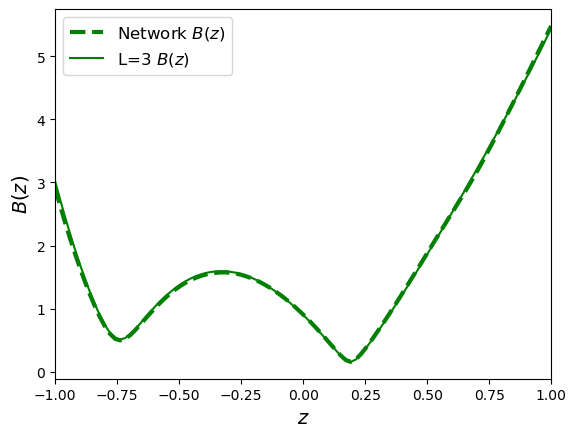

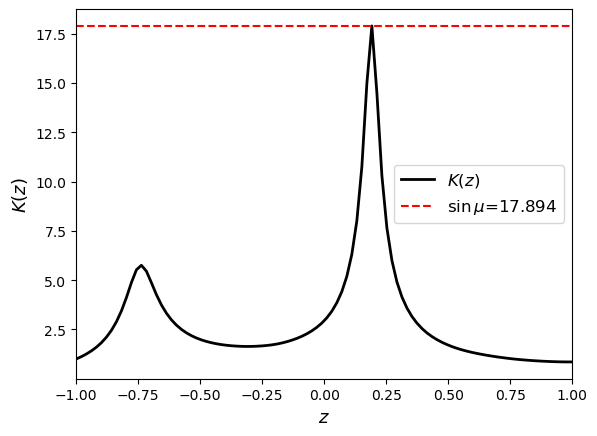

In [54]:
fig = plt.figure()
    
plt.plot(zpointseval.cpu(),modeval, '--', linewidth = 3, c='g')       
plt.plot(zpointseval.cpu(),np.abs(soll31), '-', linewidth = 1.5, c='g')   
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$B(z)$', fontsize=14)    

plt.legend(['Network $B(z)$'] + ['L=3 $B(z)$'], fontsize=12)
plt.xlim([-1,1])
plt.show()


sinmu_l3 = max(integralz.cpu())

fig = plt.figure()
plt.plot(zpointseval.cpu(),integralz.cpu(), 'k-', linewidth = 2)   
plt.plot(zpointseval.cpu(),sinmu_l3.repeat(integralz.size(dim=0)), 'r--' )   
plt.xlabel('$z$', fontsize=13)
plt.ylabel('$K(z)$', fontsize=13)    
plt.xlim([-1,1])
plt.legend(['$K(z)$','$\sin \mu$={}'.format(str(np.round(sinmu_l3.numpy(),3)))], fontsize=12)
plt.show()

Plot the phases and amplitudes

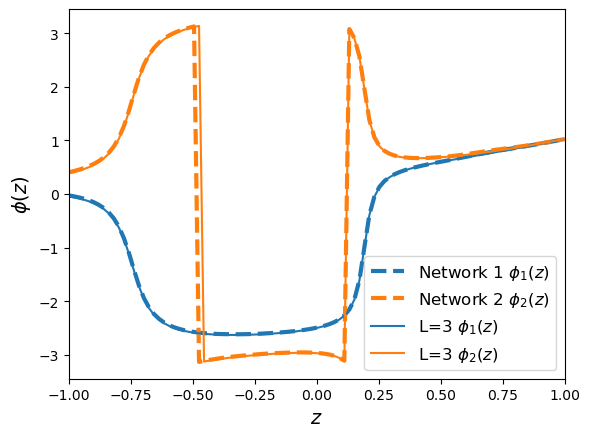

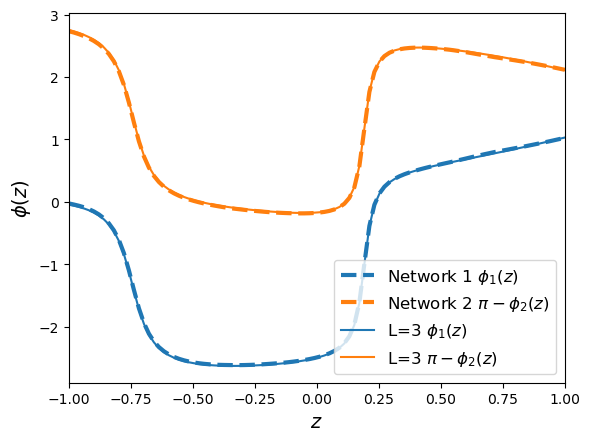

In [55]:
fig = plt.figure()

plt.plot(zpointseval.cpu(),phievals[0], '--', linewidth = 3)
plt.plot(zpointseval.cpu(), phievals[1], '--', linewidth = 3)
plt.plot(zpointseval.cpu(),np.angle(soll31), '-', linewidth = 1.5, color='tab:blue')
plt.plot(zpointseval.cpu(),np.angle(soll32), '-', linewidth = 1.5, color='tab:orange')      
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$\phi(z)$', fontsize=14)    

plt.legend(['Network {} $\phi_{}(z)$'.format(i+1, i+1) for i in range(2)] + ['L=3 $\phi_1(z)$','L=3 $\phi_2(z)$'], fontsize=12)
plt.xlim([-1,1])
plt.show()

fig = plt.figure()

plt.plot(zpointseval.cpu(),phievals[0], '--', linewidth = 3)
plt.plot(zpointseval.cpu(),reduce_domain(math.pi-phievals[1]), '--', linewidth = 3)
plt.plot(zpointseval.cpu(),np.angle(soll31), '-', linewidth = 1.5, color='tab:blue')      
plt.plot(zpointseval.cpu(),reduce_domain(math.pi-np.angle(soll32)), '-', linewidth = 1.5, color='tab:orange')      
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$\phi(z)$', fontsize=14)    

plt.legend(['Network 1 $\phi_1(z)$', 'Network 2 $\pi - \phi_2(z)$'] + ['L=3 $\phi_1(z)$','L=3 $\pi -\phi_2(z)$'], fontsize=12)
plt.xlim([-1,1])
plt.show()


In [56]:
ztest = torch.linspace(-1, 1, 100, device=device)
f_eval = deepcopy(netsolver_test.amps_net.base_f)

f_amp = f_eval(ztest.view(-1,1))

# Define the L=3 polynomial amplitude roots
ain = 2.80071+1j*4.66678
z1in = -0.743792-1j*0.0628425
z2in = 0.191248+1j*0.0291457
z3in = 1.31603+1j*0.954597

f_th = ain*(ztest-z3in)/((1-z3in))
f_th1 = (ztest-z1in)*(ztest-z2in)/((1-z1in)*(1-z2in))

f_th_re = np.real(f_th)
f_th_im = np.imag(f_th)

f_amp_tot = ((torch.flatten(f_amp[0]) + 1j *  torch.flatten(f_amp[1]) ).detach().numpy())*f_th1.numpy()

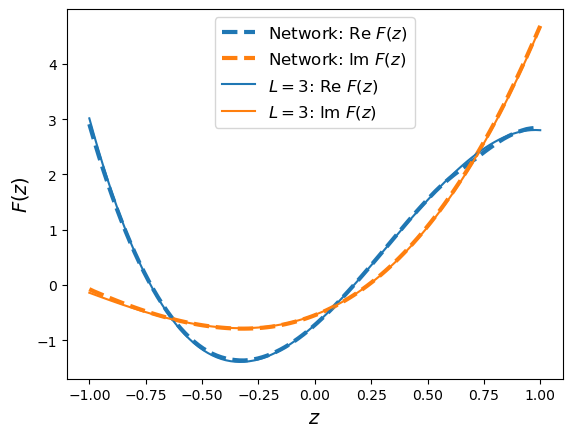

In [57]:
fig = plt.figure()
plt.plot(ztest.cpu(), np.real(f_amp_tot),'--', linewidth = 3)
plt.plot(ztest.cpu(), np.imag(f_amp_tot),'--', linewidth = 3)
plt.plot(ztest.cpu(),np.real(soll31), '-', linewidth = 1.5, color='tab:blue')
plt.plot(ztest.cpu(),np.imag(soll31), '-', linewidth = 1.5, color='tab:orange')   
plt.xlabel('$z$', fontsize=14)
plt.ylabel('$F(z)$', fontsize=14) 
plt.legend(['Network: Re $F(z)$','Network: Im $F(z)$', '$L=3$: Re $F(z)$','$L=3$: Im $F(z)$'], fontsize=12)
plt.show()

#### Do Gradient Descent when taking out multiple zeros

##### Pretrain at $z_1=1.2+0.4i$ and $z_2=1.5+0.8i$

In [41]:
init_zeros = [[1.2, 0.4], [1.5, 0.8]]

params = {'batch_size': 64,
         'epochs_num': 5000,
         'repulsive_epochs': [0, 1000],
         'learning_rate': 0.003,
         'lr_scheduler': True, 
         'beta1' : 0.9,
         'beta2' : 0.999,
         'integral_points': 25,
         'method_int': 'trapz',
         'layer_list': [64, 64, 64, 64],
         'loss': 'MSE',
         'scaled_loss': True,
         'zeros': init_zeros,
         'disconnected': False,
         'complex_pred': True,
         'p_value': 2,
         'lambda_repulsive':2.0}

network_fixed3 = deepcopy(netsolver_fixed.amps_net)
network_fixed3.zeros = init_zeros

netsolver_fixed3 = train_run(params, device, seed_num=42, optim_name='Adam', amps_net=network_fixed3)

  0%|          | 0/5000 [00:00<?, ?epoch/s]

In [43]:
zpointseval3, _, _, _, _, eval_scale3, eval_base3 = eval_run_amp(netsolver_fixed3, params, device)
integralz3 = sin_mu_integral(netsolver_fixed3, zpointseval3)
sinmu_l33 = max(integralz3.cpu())

##### Do the gradient descent. Can also load results later

In [45]:
# Prepare the overall parameters
params_scan = deepcopy(params)
params_scan['epochs_num'] = 500
params_scan['zeros'] = init_zeros
params_scan['lambda_repulsive'] = 0.0

# Prepare the loggers
log_sinmu_scan2 = {'points_visit': [init_zeros], 'sinmu': [], 'gradients': [], 'networks': [], 'loss_base': [],
                  'loss_scale': []}

# Do the initial point run
init_net = deepcopy(netsolver_fixed3.amps_net)

# Get the initial stats
init_sinmu = sinmu_l33
log_sinmu_scan2['loss_base'].append(eval_base3)
log_sinmu_scan2['loss_scale'].append(eval_scale3)
log_sinmu_scan2['sinmu'].append(init_sinmu)
log_sinmu_scan2['networks'].append(init_net)

# Prepare the parameters for the finite difference
epsilon = 0.001
lr = 0.005
style = 'central'
max_pts = 150
small_grad = False

In [49]:
 # Loop while we have a large gradient or we have not exceeded the budget
while not small_grad and len(log_sinmu_scan2['points_visit']) < max_pts:

    # Calculate the gradient
    grad_x1 = calculate_grad(params_scan, epsilon, init_zeros, init_sinmu, style, init_net,
                             seed=42, dim=0, zero_num=0)
    grad_y1 = calculate_grad(params_scan, epsilon, init_zeros, init_sinmu, style, init_net,
                             seed=42, dim=1, zero_num=0)
    grad_x2 = calculate_grad(params_scan, epsilon, init_zeros, init_sinmu, style, init_net,
                             seed=42, dim=0, zero_num=1)
    grad_y2 = calculate_grad(params_scan, epsilon, init_zeros, init_sinmu, style, init_net,
                             seed=42, dim=1, zero_num=1)
    log_sinmu_scan2['gradients'].append([[grad_x1, grad_y1], [grad_x2, grad_y2]])

    small_grad = (grad_x1 ** 2 + grad_y1 ** 2 + grad_x2 ** 2 + grad_y2 ** 2) < 0.01

# Update the value of the zero location (put some cutoff on the gradient)
    new_zero_x1 = init_zeros[0][0] - lr * min(abs(grad_x1), 5) * grad_x1 / abs(grad_x1)
    new_zero_y1 = init_zeros[0][1] - lr * min(abs(grad_y1), 5) * grad_y1 / abs(grad_y1)
    new_zero_x2 = init_zeros[1][0] - lr * min(abs(grad_x2), 5) * grad_x2 / abs(grad_x2)
    new_zero_y2 = init_zeros[1][1] - lr * min(abs(grad_y2), 5) * grad_y2 / abs(grad_y2)
    init_zeros = [[new_zero_x1, new_zero_y1], [new_zero_x2, new_zero_y2]]

    params_scan['zeros'] = init_zeros

    # Update the new initial net and train it at that point
    init_net = deepcopy(init_net)
    init_net.zeros = init_zeros
    netsolver = train_run(params_scan, device, seed_num=42, optim_name='Adam', amps_net=init_net)

    zpointseval, _, _, _, _, eval_loss_scaled, eval_loss_base = eval_run_amp(netsolver, params_scan, device,
                                                                             steps_eval=100,
                                                                             num=None)
    init_sinmu = max(sin_mu_integral(netsolver, zpointseval).cpu())

    log_sinmu_scan2['points_visit'].append(init_zeros)
    log_sinmu_scan2['loss_base'].append(eval_loss_base)
    log_sinmu_scan2['loss_scale'].append(eval_loss_scaled)
    log_sinmu_scan2['sinmu'].append(init_sinmu)
    log_sinmu_scan2['networks'].append(deepcopy(init_net))

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/50 [00:00<?, ?epoch/s]

##### Plot the results

Start by loading if necessary

In [58]:
load_results = True

if load_results:
    path_save = 'Data/Gradient_descent/traj_5_'
    log_sinmu_scan2 = {'points_visit': [], 'sinmu': [], 'gradients':[], 'loss_base':[], 'loss_scale':[]}

    for key in log_sinmu_scan2.keys():
        end_path = '_gradient.npy'
        path = path_save + str(key) + end_path
        data_in = np.load(path)
        log_sinmu_scan2[key] = data_in

Cutoff when the loss starts to blow up

In [61]:
cutoff = 50
print(log_sinmu_scan2['sinmu'][cutoff])

2.5701616


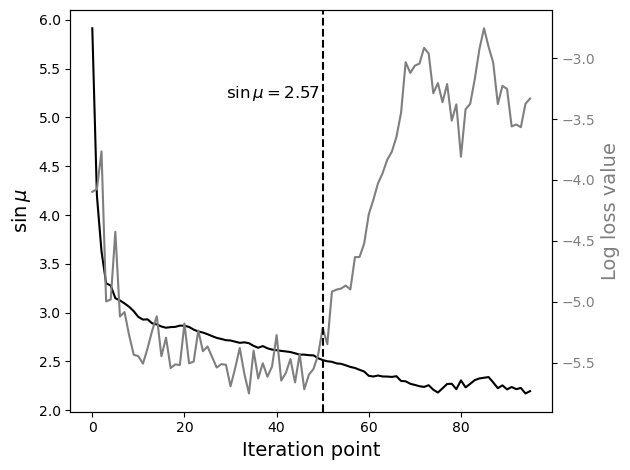

In [59]:
cutoff = 50
cutoffs = 4

fig, ax1 = plt.subplots()
ax1.set_xlabel('Iteration point', fontsize =14)
ax1.set_ylabel('$\sin \mu$', color='black', fontsize =14)
ax1.plot(log_sinmu_scan2['sinmu'][cutoffs:100], color='black')
ax1.tick_params(axis='y', labelcolor='black')

plt.text(cutoff-21, 5.2, '$\sin \mu = 2.57$', fontsize=12)
ax2 = ax1.twinx()  
ax2.set_ylabel('Log loss value', color='tab:grey', fontsize =14)  
ax2.plot(np.log10(log_sinmu_scan2['loss_scale'][cutoffs:100]), color='tab:grey')
ax2.tick_params(axis='y', labelcolor='tab:grey')

plt.axvline(x = cutoff, color = 'k', linestyle='--')
fig.tight_layout()  
plt.show()

Plot the $z_1,z_2$ trajectories

In [68]:
points1 = log_sinmu_scan2['points_visit'][cutoffs:cutoff,0]
points2 = log_sinmu_scan2['points_visit'][cutoffs:cutoff,1]

utemp1 = np.diff(points1[:,0])
vtemp1 = np.diff(points1[:,1])
utemp2 = np.diff(points2[:,0])
vtemp2 = np.diff(points2[:,1])

pos_ar_x1 = points1[:,0][:-1] + utemp1/2
pos_ar_y1 = points1[:,1][:-1] + vtemp1/2
normtemp1 = np.sqrt(utemp1**2+vtemp1**2) 

pos_ar_x2 = points2[:,0][:-1] + utemp2/2
pos_ar_y2 = points2[:,1][:-1] + vtemp2/2
normtemp2 = np.sqrt(utemp2**2+vtemp2**2) 

sn=10

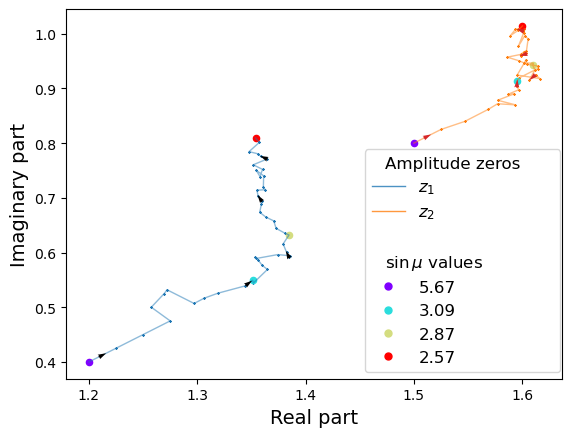

In [69]:
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

indices = [0, int(len(points1)*0.25), int(len(points1)*0.5) ,-1]
color_r = cm.rainbow(np.linspace(0, 1, len(indices)))

sinmus = [log_sinmu_scan2['sinmu'][:cutoff][i] for i in indices]


fig = plt.figure()


plt.scatter(points1[:, 0], points1[:, 1],s=1, marker='x', color='tab:blue')
plt.plot(points1[:, 0], points1[:, 1],color='tab:blue', linewidth=1, alpha=0.5)
plt.quiver(pos_ar_x1[::sn], pos_ar_y1[::sn], utemp1[::sn]/normtemp1[::sn], vtemp1[::sn]/normtemp1[::sn], angles="xy", zorder=5, pivot="mid", scale=60,color='k')
    
plt.scatter(points2[:, 0], points2[:, 1],s=1, marker='x',color='tab:orange')
plt.plot(points2[:, 0], points2[:, 1],color='tab:orange', linewidth=1, alpha=0.5)
plt.quiver(pos_ar_x2[::sn], pos_ar_y2[::sn], utemp2[::sn]/normtemp2[::sn], vtemp2[::sn]/normtemp2[::sn], angles="xy", zorder=5, pivot="mid", scale=60,color='tab:red')

for i, ind in enumerate(indices):
    plt.scatter(points1[ind, 0], points1[ind, 1],s=20, color=color_r[i],marker='o')
    plt.scatter(points2[ind, 0], points2[ind, 1],s=20, color=color_r[i],marker='o')


plt.xlabel('Real part', fontsize=14)
plt.ylabel('Imaginary part', fontsize=14)

legend_contents = [
        (Patch(visible=False), 'Amplitude zeros'),
        (Line2D([0], [0], color='tab:blue', lw=1,alpha=0.8), '$z_1$'),
        (Line2D([0], [0], color='tab:orange', lw=1,alpha=0.8), '$z_2$'),

        (Patch(visible=False), ''),  # spacer
    
        (Patch(visible=False), '$\sin \mu$ values'),
    ] + [(Line2D([0], [0], marker='o', markeredgecolor=color_r[i],markerfacecolor=color_r[i], markersize=5,color='w'), str(round(sinmus[i],2))) for i in range(len(color_r))]


leg = fig.legend(*zip(*legend_contents),bbox_to_anchor=(0.41, 0.105, 0.5, 0.5), fontsize=12)
           
hpacker_padding = 2
for handle, label in zip(leg.legendHandles, leg.texts):
    if not handle.get_visible():
        widths = [leg.handlelength, leg.handletextpad]
        offset_points = sum(leg._fontsize * w for w in widths)
        offset_pixels = leg.figure.canvas.get_renderer().points_to_pixels(offset_points) + hpacker_padding
        label.set_position((-offset_pixels+15, 0))

plt.show()